# SOLVERS

Importing the relevant libraries:

In [1]:
import numpy as np
import networkx as nx

import matplotlib.pyplot as plt
import PIL

import time

from mip import *
import cplex
from cplex.exceptions import CplexError

Defining the generator:

In [2]:
# Class that will help create a connected graph

class UnionFind:
    def __init__(self, n):
        self.n = n  # number of trees in the forest
        self.v = [i for i in range(n)]  # initialize each disjoint set

    def find(self, u):
        while u != self.v[u]:
            self.v[u] = self.v[self.v[u]]  # compression technique
            u = self.v[u]
            
        return u
    
    def union(self, u, v):
        root_u, root_v = self.find(u), self.find(v)
        
        if root_u == root_v:
            return False  # union was not performed
        else:
            self.v[root_v] = root_u
            self.n -= 1

            return True  # union was not performed
        
# Defining the generator
        
class GraphGenerator:
    def __init__(self, N=100):
        self.N = N  # number os cells (default is a 10x10 grid)
        self.edges = self.generate_edges()
        
    def water_network(self):        
        # Copy the edges and create a disjoint set for each cell
        edges = self.edges.copy()
        forest = UnionFind(self.N)
        
        # Generate a graph
        G = nx.Graph()
        
        # Adding nodes
        # Initial value of flow is True because, initially, it is a connected graph
        for v in range(self.N):
            G.add_node(v, node_prop=None, flow=True, image=images["node_water"])
            
        step = 2*(self.N**0.5) + 2
            
        origin = np.random.randint(0, self.N)
        dest = np.random.choice([v for v in range(self.N) if v < origin-step or v > origin+step])
    
        G.nodes[origin]["node_prop"] = "origin"
        G.nodes[origin]["image"] = images["origin"]
        G.nodes[dest]["node_prop"] = "dest"
        G.nodes[dest]["image"] = images["dest"]
        
        # Adding edges
        # Makes sure that the initial graph will be connected
        # Edges with endpoint at origin or destination are marked as red
        # This color represents the constraint that prevents the deletion of an edge
        while forest.n > 1:
            v, w = edges.pop(np.random.randint(0, len(edges)))
            forest.union(v, w)
            G.add_edge(v, w, color="red" if G.nodes[v]["node_prop"] or G.nodes[w]["node_prop"] else "blue")
            
        return G
    
    def military_network(self):        
        # Copy the edges and create a disjoint set for each cell
        edges = self.edges.copy()
        forest = UnionFind(self.N)
        
        # Generate a graph
        G = nx.Graph()
        
        # Adding nodes
        endurances = np.random.choice(np.arange(1, 4), self.N, [0.2, 0.2, 0.6])
        for v, e in enumerate(endurances):
            G.add_node(v, node_prop=None, endurance=e, provided=True, image=images[f"base_{e}"])
            
        headquarters = np.random.randint(0, self.N)
    
        G.nodes[headquarters]["node_prop"] = "headquarters"
        G.nodes[headquarters]["endurance"] = 10000  # headquarters is the most difficult enemy military installation to attack
        G.nodes[headquarters]["image"] = images["headquarters"]
        
        # Adding edges
        # Makes sure that the initial graph will be connected
        while forest.n > 1:
            v, w = edges.pop(np.random.randint(0, len(edges)))
            forest.union(v, w)
            G.add_edge(v, w)
            
        # Harder to attack military installations adjacent to headquarters
        for v in G[headquarters]:
            G.nodes[v]["node_prop"] = "secure"
            G.nodes[v]["endurance"] = 100
                
        return G
                
    def available_edges(self, v):
        shape = int(self.N**0.5)  # takes into account the dimensions of the grid
        
        available_edges = []
        if (v+1) % shape != 0:
            available_edges.append((v, v+1))
        if v+shape < self.N:
            available_edges.append((v, v+shape))

        return available_edges  # possible edges in cell v

    def generate_edges(self):
        edges = []
        
        for v in range(self.N):
            edges.extend(self.available_edges(v))

        return edges

Defining function to display the water distribution network:

In [3]:
# Load images and defining constants

files = {"node_water" : "../media/node_water.png",
         "node" : "../media/node.png",
         "origin" : "../media/origin.png",
         "dest" : "../media/dest.png",
         "headquarters" : "../media/headquarters.png",
         "base_1" : "../media/base_1.png",
         "base_2" : "../media/base_2.png",
         "base_3" : "../media/base_3.png"}

images = {name : PIL.Image.open(file) for name, file in files.items()}

pos = {
    0: np.array([-0.51696583,  0.93714869]),
    1: np.array([-0.56742641,  0.82253354]),
    2: np.array([-0.62719935,  0.6729658 ]),
    3: np.array([-0.68765874,  0.50267799]),
    4: np.array([-0.74382698,  0.32035925]),
    5: np.array([-0.7941627 ,  0.13217055]),
    6: np.array([-0.83666331, -0.05578246]),
    7: np.array([-0.86996528, -0.23595114]),
    8: np.array([-0.89094869, -0.39926238]),
    9: np.array([-0.89163946, -0.53053518]),
    10: np.array([-0.38733367,  0.91693445]),
    11: np.array([-0.43712311,  0.80092016]),
    12: np.array([-0.49716983,  0.65037759]),
    13: np.array([-0.5581313 ,  0.48008344]),
    14: np.array([-0.61608378,  0.29792199]),
    15: np.array([-0.66749135,  0.10980975]),
    16: np.array([-0.71289509, -0.07778028]),
    17: np.array([-0.74890233, -0.25729352]),
    18: np.array([-0.77561893, -0.41942676]),
    19: np.array([-0.79111634, -0.54694834]),
    20: np.array([-0.21763917,  0.88636633]),
    21: np.array([-0.26705243,  0.77026095]),
    22: np.array([-0.32663326,  0.61904439]),
    23: np.array([-0.38874385,  0.44821624]),
    24: np.array([-0.44925398,  0.26544396]),
    25: np.array([-0.503791  ,  0.07726947]),
    26: np.array([-0.55185069, -0.1106987 ]),
    27: np.array([-0.59258626, -0.28972098]),
    28: np.array([-0.6253616 , -0.45151689]),
    29: np.array([-0.64908797, -0.57808267]),
    30: np.array([-0.0265184 ,  0.84316223]),
    31: np.array([-0.07569189,  0.72768255]),
    32: np.array([-0.13522642,  0.57630147]),
    33: np.array([-0.19846837,  0.4052692 ]),
    34: np.array([-0.26184534,  0.22231268]),
    35: np.array([-0.31914537,  0.03504394]),
    36: np.array([-0.37176953, -0.15155968]),
    37: np.array([-0.41760519, -0.33009058]),
    38: np.array([-0.45635494, -0.49089175]),
    39: np.array([-0.48610726, -0.61664203]),
    40: np.array([0.17306041, 0.7870388 ]),
    41: np.array([0.12523073, 0.67174665]),
    42: np.array([0.06542014, 0.52135366]),
    43: np.array([0.00057418, 0.35038808]),
    44: np.array([-0.06446017,  0.16881244]),
    45: np.array([-0.12665467, -0.01764184]),
    46: np.array([-0.18358474, -0.20284045]),
    47: np.array([-0.23517585, -0.37993201]),
    48: np.array([-0.28008131, -0.5395554 ]),
    49: np.array([-0.31520095, -0.66452575]),
    50: np.array([0.37367169, 0.71735255]),
    51: np.array([0.3261134 , 0.60349739]),
    52: np.array([0.26568384, 0.4533447 ]),
    53: np.array([0.20029084, 0.28232821]),
    54: np.array([0.13188387, 0.10076766]),
    55: np.array([ 0.06580071, -0.08512693]),
    56: np.array([ 0.00327433, -0.26912593]),
    57: np.array([-0.05435863, -0.44475043]),
    58: np.array([-0.10542573, -0.60277577]),
    59: np.array([-0.14543593, -0.72631346]),
    60: np.array([0.56559421, 0.6370167 ]),
    61: np.array([0.51816683, 0.52173925]),
    62: np.array([0.45742793, 0.37180072]),
    63: np.array([0.39078859, 0.20081206]),
    64: np.array([0.32068581, 0.01991257]),
    65: np.array([ 0.25061104, -0.16499424]),
    66: np.array([ 0.18319807, -0.34754591]),
    67: np.array([ 0.11983138, -0.52158416]),
    68: np.array([ 0.06301685, -0.6776568 ]),
    69: np.array([ 0.0186711 , -0.79902472]),
    70: np.array([0.73944725, 0.54937204]),
    71: np.array([0.69356718, 0.43354057]),
    72: np.array([0.63327831, 0.28299777]),
    73: np.array([0.56640157, 0.11362039]),
    74: np.array([ 0.49475948, -0.06586195]),
    75: np.array([ 0.42219951, -0.24879945]),
    76: np.array([ 0.3508318 , -0.42919368]),
    77: np.array([ 0.28323608, -0.60006218]),
    78: np.array([ 0.22174755, -0.75283945]),
    79: np.array([ 0.17375926, -0.87138453]),
    80: np.array([0.88851998, 0.46293385]),
    81: np.array([0.84461033, 0.34637144]),
    82: np.array([0.78622939, 0.19742634]),
    83: np.array([0.71890696, 0.03077887]),
    84: np.array([ 0.64701115, -0.14610216]),
    85: np.array([ 0.57298256, -0.32634267]),
    86: np.array([ 0.4991802 , -0.50380042]),
    87: np.array([ 0.42843525, -0.67146086]),
    88: np.array([ 0.36371804, -0.82063715]),
    89: np.array([ 0.31246931, -0.93602742]),
    90: np.array([1.        , 0.39207751]),
    91: np.array([0.95865002, 0.27626818]),
    92: np.array([0.90164736, 0.12886004]),
    93: np.array([ 0.83495187, -0.03602707]),
    94: np.array([ 0.76248999, -0.21032434]),
    95: np.array([ 0.68749931, -0.38815742]),
    96: np.array([ 0.61223136, -0.5631032 ]),
    97: np.array([ 0.53957587, -0.72800535]),
    98: np.array([ 0.47280378, -0.87360199]),
    99: np.array([ 0.41929671, -0.98512662])
}

def plot_military_network(network):
    fig, ax = plt.subplots(figsize=(24, 16))

    nx.draw_networkx_edges(network, pos=pos, ax=ax, width=6, edge_color="blue")
    nx.draw_networkx_edge_labels(network, pos, {edge : str(edge) for edge in network.edges})

    tr_figure = ax.transData.transform
    tr_axes = fig.transFigure.inverted().transform

    icon_size = (ax.get_xlim()[1] - ax.get_xlim()[0]) * 0.01
    icon_center = icon_size / 2.0

    for n in network.nodes:
        xf, yf = tr_figure(pos[n])
        xa, ya = tr_axes((xf, yf))

        if network.nodes[n]["node_prop"] == "headquarters":
            a = plt.axes([xa - 2*icon_center, ya - 2*icon_center, 2*icon_size, 2*icon_size])
        else:
            a = plt.axes([xa - icon_center, ya - icon_center, icon_size, icon_size])

        a.imshow(network.nodes[n]["image"])
        a.axis("off")

    plt.show()

## MIP Solver

Class to perform the otimization:

In [4]:
def mip_military_network(network, fire_power=6):
    # Create a model
    model = Model(sense=MAXIMIZE, solver_name=CBC)
    
    # Defining the variables
    x = [None]*network.number_of_nodes()
    y = [None]*network.number_of_nodes()
    
    for i in network.nodes:
        x[i] = model.add_var(var_type=BINARY, name=f"x_{i}")
        y[i] = model.add_var(var_type=BINARY, name=f"y_{i}")
        
        if network.nodes[i]["node_prop"] == "headquarters":
            model += x[i] == 0
            model += y[i] == 0
        elif network.nodes[i]["node_prop"] == "secure":
            model += y[i] == 0
    
    # Defining the objective function
    model.objective = xsum(x_i for x_i in x)
    
    # Defining the constraints
    model += xsum(network.nodes[i]["endurance"]*y_i
                  for i, y_i in enumerate(y)) <= fire_power
    
    for v, w in network.edges:
        model += y[v] + y[w] >= x[v] - x[w]
        model += y[v] + y[w] >= x[w] - x[v]

    return model

Testing the MIP solver:

In [5]:
# Generating a graph representing a water distribution network

generator = GraphGenerator()

military_network = generator.military_network()

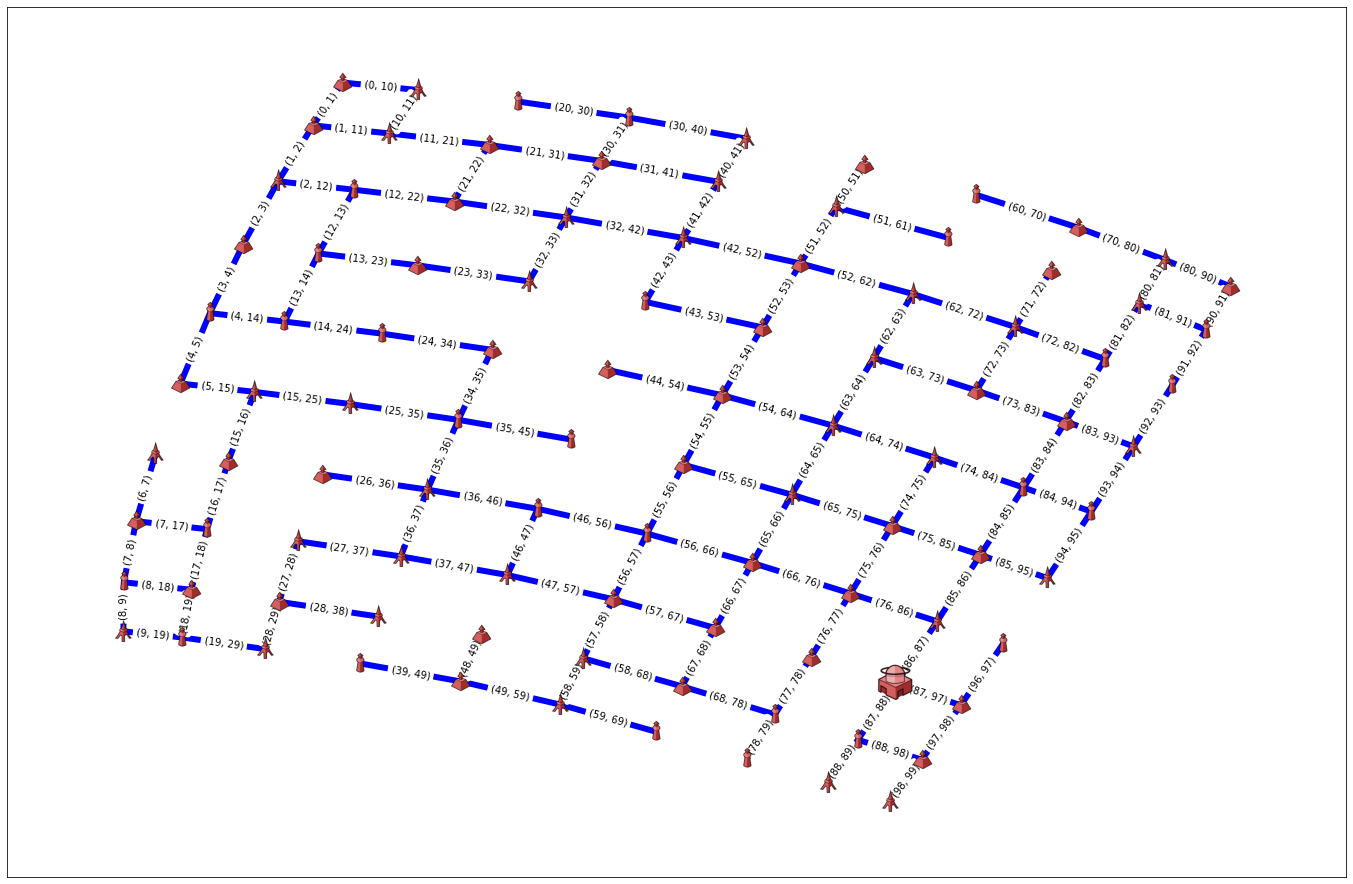

In [6]:
plot_military_network(military_network)

In [7]:
model = mip_military_network(military_network)
model.optimize()

Welcome to the CBC MILP Solver 
Version: devel 
Build Date: Nov 15 2020 

Starting solution of the Linear programming relaxation problem using Primal Simplex

Coin0506I Presolve 252 (-18) rows, 192 (-8) columns and 1090 (-71) elements
Clp1000I sum of infeasibilities 0 - average 0, 183 fixed columns
Coin0506I Presolve 8 (-244) rows, 7 (-185) columns and 19 (-1071) elements
Clp0029I End of values pass after 7 iterations
Clp0000I Optimal - objective value 93
Clp0000I Optimal - objective value 93
Coin0511I After Postsolve, objective 93, infeasibilities - dual 0 (0), primal 0 (0)
Clp0014I Perturbing problem by 0.001% of 1.0051819 - largest nonzero change 1.9401761e-05 ( 0.00097008804%) - largest zero change 2.9576128e-05
Clp0000I Optimal - objective value 93.75
Clp0000I Optimal - objective value 93.75
Clp0000I Optimal - objective value 93.75
Coin0511I After Postsolve, objective 93.75, infeasibilities - dual 0 (0), primal 0 (0)
Clp0032I Optimal objective 93.75 - 0 iterations time 0.012, Pres

<OptimizationStatus.OPTIMAL: 0>

In [8]:
print(f"Optimization status is \"{model.status.name}\".")
      
print()
      
print("Getting the results:")
print(f"Optimal solution = {model.objective_value}")

print()

# Displaying variables that have been assigned a 1
for v in model.vars[1::2]:
    if v.x:
        print(f"{v.name} = {v.x}")

Optimization status is "OPTIMAL".

Getting the results:
Optimal solution = 92.0

y_76 = 1.0
y_85 = 1.0


In [9]:
# Removing nodes obtained by the model and checking the result

for node, var in enumerate(model.vars[1::2]):
    if var.x:
        military_network.remove_node(node)

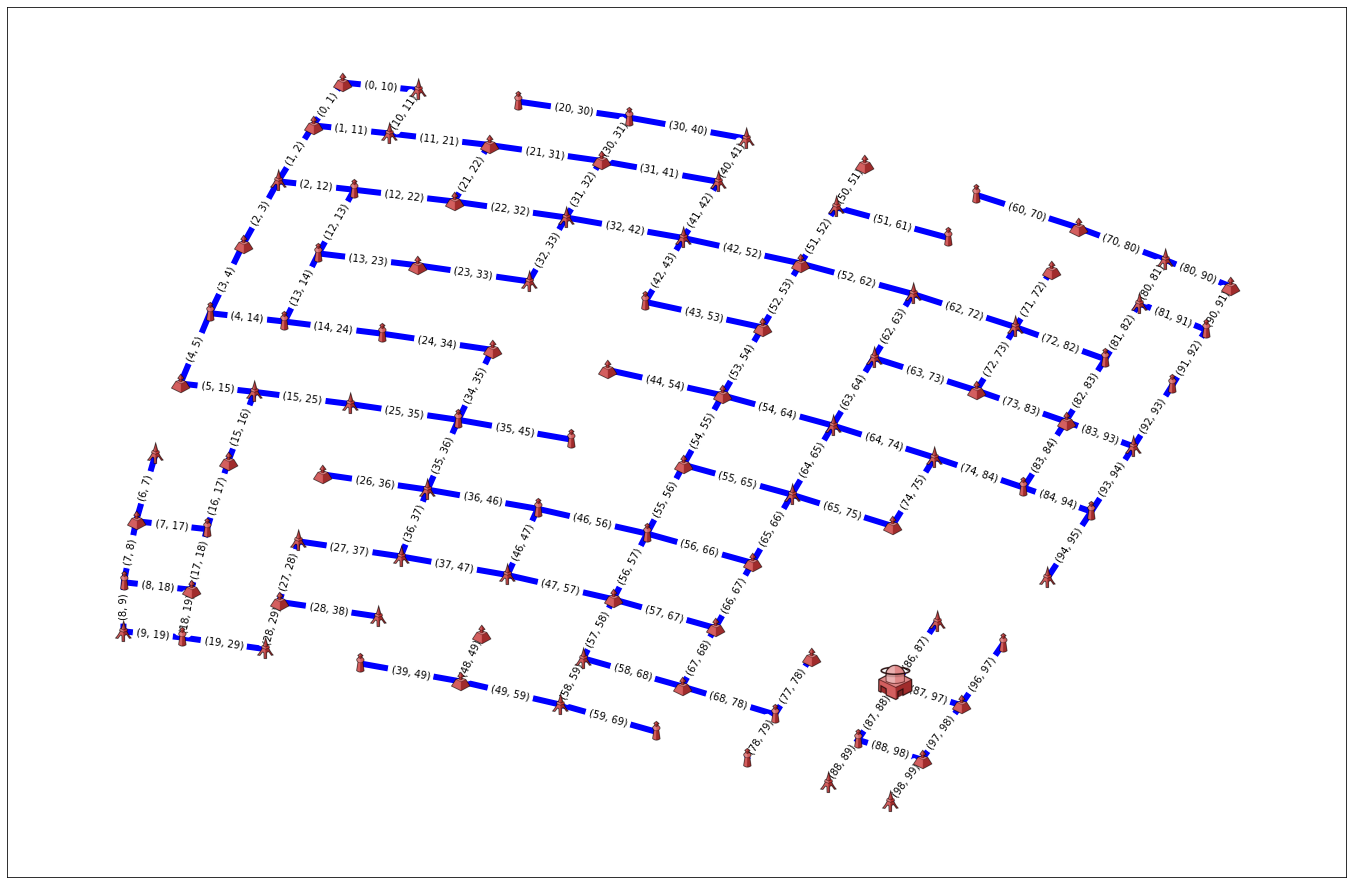

In [10]:
plot_military_network(military_network)

## CPLEX Solver

In [11]:
def cplex_military_network(network, fire_power=6):
    # Create a model
    model = cplex.Cplex()
    model.objective.set_sense(model.objective.sense.maximize)

    model.parameters.lpmethod.set(model.parameters.lpmethod.values.network)

    # Create variables
    x = list(model.variables.add(obj=[1]*network.number_of_nodes(), types=["B"]*network.number_of_nodes()))
    y = list(model.variables.add(obj=[0]*network.number_of_nodes(), types=["B"]*network.number_of_nodes()))
    
    # Defining the constraints
    for i in network.nodes:
        if network.nodes[i]["node_prop"]:
            if network.nodes[i]["node_prop"] == "headquarters":
                model.linear_constraints.add(lin_expr=[[[x[i]], [1]]], senses=["E"], rhs=[0])
                
            model.linear_constraints.add(lin_expr=[[[y[i]], [1]]], senses=["E"], rhs=[0])
    
    model.linear_constraints.add(lin_expr=[[y, [int(e) for e in nx.get_node_attributes(network, "endurance").values()]]],
                                 senses=["L"], rhs=[fire_power])

    for v, w in network.edges:
        model.linear_constraints.add(lin_expr=[[[y[v], y[w], x[v], x[w]], [-1, -1, 1, -1]]],
                                     senses=["L"], rhs=[0])
        model.linear_constraints.add(lin_expr=[[[y[v], y[w], x[w], x[v]], [-1, -1, 1, -1]]],
                                     senses=["L"], rhs=[0])
    
    return model

Testing the CPLEX solver:

In [12]:
# Generating a graph representing a water distribution network

generator = GraphGenerator()

military_network = generator.military_network()

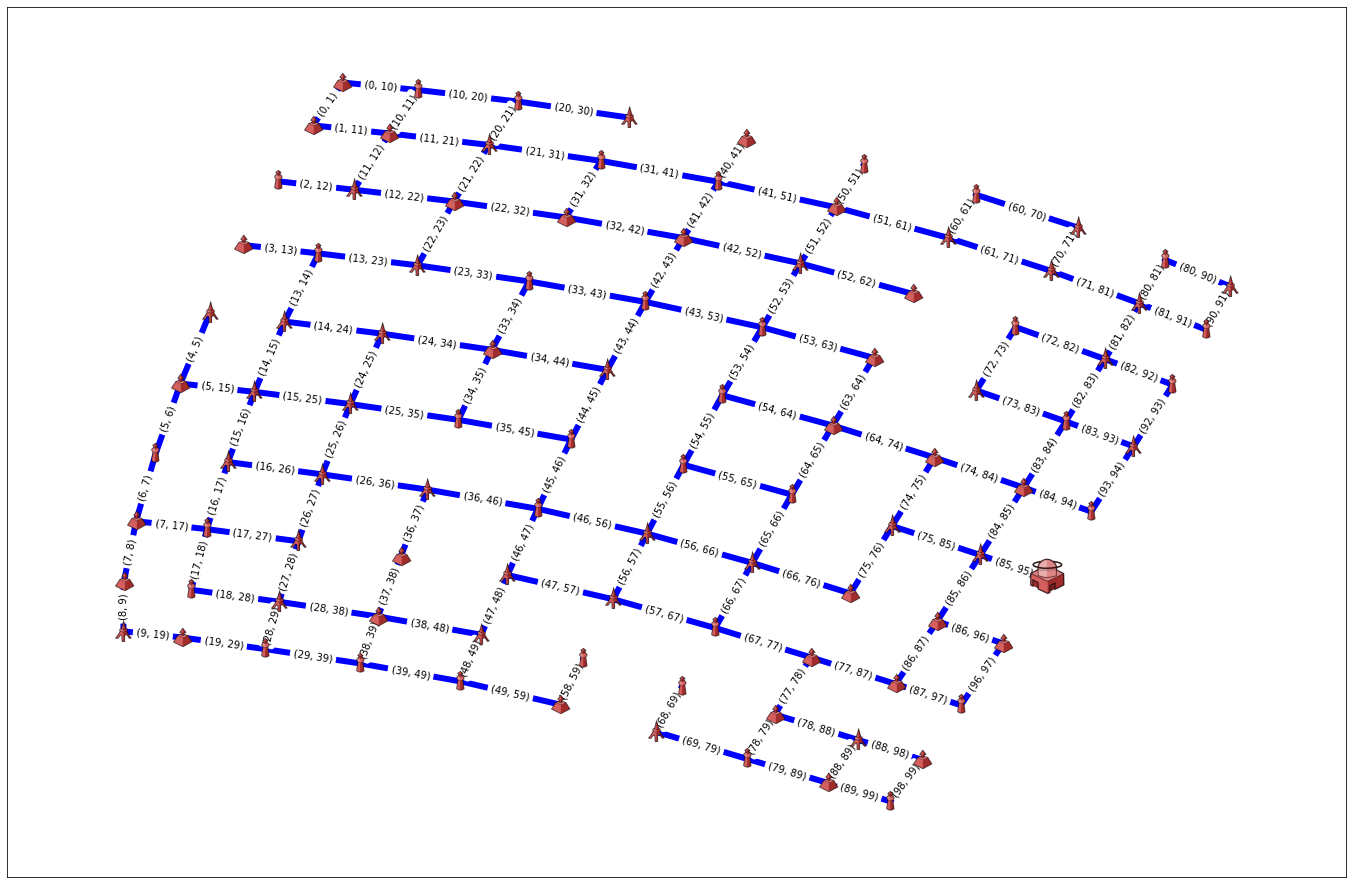

In [13]:
plot_military_network(military_network)

In [14]:
model = cplex_military_network(military_network)
model.solve()

Version identifier: 22.1.0.0 | 2022-03-09 | 1a383f8ce
CPXPARAM_Read_DataCheck                          1
CPXPARAM_LPMethod                                3
Found incumbent of value 0.000000 after 0.00 sec. (0.02 ticks)
Tried aggregator 2 times.
MIP Presolve eliminated 15 rows and 8 columns.
MIP Presolve modified 7 coefficients.
Aggregator did 3 substitutions.
Reduced MIP has 266 rows, 189 columns, and 1139 nonzeros.
Reduced MIP has 189 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (1.22 ticks)
Probing time = 0.00 sec. (0.07 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 266 rows, 189 columns, and 1139 nonzeros.
Reduced MIP has 189 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (0.86 ticks)
Probing time = 0.00 sec. (0.07 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.00 sec. (0.

In [15]:
print(f"Optimization status is \"{model.solution.status[model.solution.get_status()]}\".")
      
print()
      
print("Getting the results:")
print(f"Optimal solution = {model.solution.get_objective_value()}")

print()

# Displaying variables that have been assigned a 1
for node, value in enumerate(model.solution.get_values()[100:]):
    if value:
        print(f"y_{node} = {value}")

Optimization status is "MIP_optimal".

Getting the results:
Optimal solution = 85.0

y_67 = 1.0
y_75 = 1.0
y_84 = 1.0


In [16]:
# Removing edges obtained by the model and checking the result
        
for node, value in enumerate(model.solution.get_values()[100:]):
    if value:
        military_network.remove_node(node)

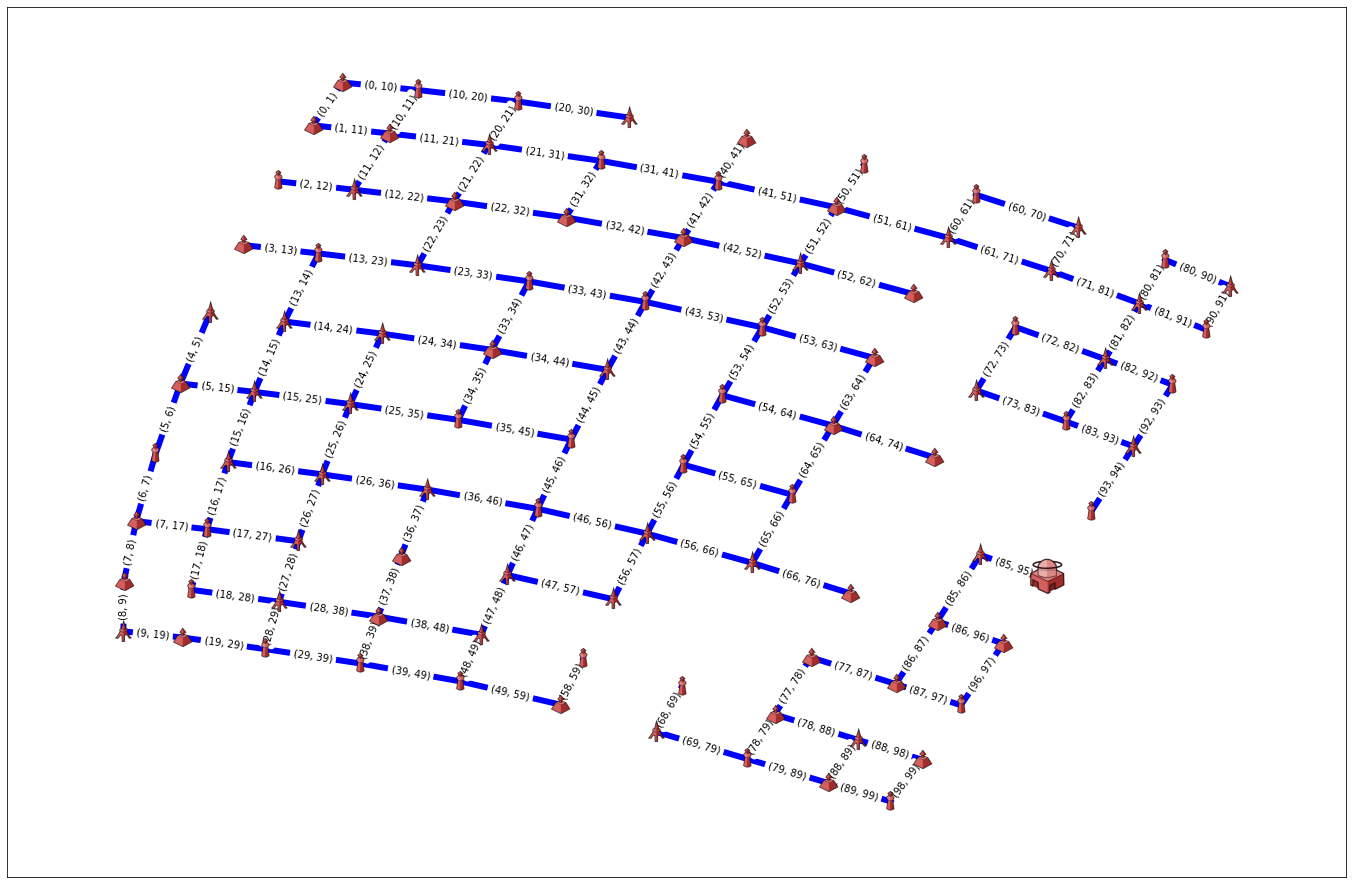

In [17]:
plot_military_network(military_network)

## Comparing the Solvers

Performing several iterations of the two solvers:

In [18]:
generator = GraphGenerator()

N = 100

time_mip = np.zeros(N)
time_cplex = np.zeros(N)

objective_mip = np.zeros(N)
objective_cplex = np.zeros(N)

for i in range(N):
    military_network = generator.military_network()
    
    start_mip = time.time()
    model_mip = mip_military_network(military_network)
    model_mip.optimize()
    end_mip = time.time()
    
    start_cplex = time.time()
    model_cplex = cplex_military_network(military_network)
    model_cplex.solve()
    end_cplex = time.time()
    
    time_mip[i] = end_mip - start_mip
    time_cplex[i] = end_cplex - start_cplex
    
    objective_mip[i] = model_mip.objective_value
    objective_cplex[i] = model_cplex.solution.get_objective_value()

Cgl0002I 5 variables fixed
Cgl0003I 0 fixed, 0 tightened bounds, 7 strengthened rows, 0 substitutions
Cgl0004I processed model has 252 rows, 192 columns (192 integer (192 of which binary)) and 1083 elements
Coin3009W Conflict graph built in 0.000 seconds, density: 0.267%
Cgl0015I Clique Strengthening extended 0 cliques, 0 were dominated
Cbc0038I Initial state - 0 integers unsatisfied sum - 4.44089e-16
Cbc0038I Solution found of -92
Cbc0038I Before mini branch and bound, 192 integers at bound fixed and 0 continuous
Cbc0038I Mini branch and bound did not improve solution (0.03 seconds)
Cbc0038I After 0.03 seconds - Feasibility pump exiting with objective of -92 - took 0.00 seconds
Cbc0012I Integer solution of -92 found by feasibility pump after 0 iterations and 0 nodes (0.03 seconds)
Cbc0001I Search completed - best objective -92, took 0 iterations and 0 nodes (0.03 seconds)
Cbc0035I Maximum depth 0, 0 variables fixed on reduced cost
Total time (CPU seconds):       0.03   (Wallclock seco

MIP Presolve eliminated 95 rows and 67 columns.
MIP Presolve modified 6 coefficients.
Aggregator did 63 substitutions.
Reduced MIP has 67 rows, 44 columns, and 221 nonzeros.
Reduced MIP has 44 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (0.43 ticks)
Probing time = 0.00 sec. (0.01 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 67 rows, 44 columns, and 221 nonzeros.
Reduced MIP has 44 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.13 ticks)
Represolve time = 0.02 sec. (0.71 ticks)
Probing time = 0.00 sec. (0.01 ticks)
Clique table members: 6.
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.00 sec. (0.29 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                     

MIP Presolve modified 6 coefficients.
Aggregator did 3 substitutions.
Reduced MIP has 263 rows, 185 columns, and 1121 nonzeros.
Reduced MIP has 185 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (1.09 ticks)
Probing time = 0.00 sec. (0.07 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 263 rows, 185 columns, and 1121 nonzeros.
Reduced MIP has 185 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (0.85 ticks)
Probing time = 0.00 sec. (0.07 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.00 sec. (0.31 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                            0.0000       97.0000              --- 
*     0+    0                            2.0000       97.0000

Cbc0038I Pass  25: suminf.    5.00000 (10) obj. -87.5 iterations 8
Cbc0038I Pass  26: suminf.    5.00000 (10) obj. -87.5 iterations 5
Cbc0038I Pass  27: suminf.    5.00000 (10) obj. -87.5 iterations 3
Cbc0038I Pass  28: suminf.    6.00000 (20) obj. -83.25 iterations 27
Cbc0038I Pass  29: suminf.    5.00000 (10) obj. -86.5 iterations 30
Cbc0038I Pass  30: suminf.    5.00000 (10) obj. -86.5 iterations 2
Cbc0038I No solution found this major pass
Cbc0038I Before mini branch and bound, 158 integers at bound fixed and 0 continuous
Cbc0038I Full problem 262 rows 192 columns, reduced to 53 rows 30 columns
Cbc0038I Mini branch and bound improved solution from 1.79769e+308 to -84 (0.10 seconds)
Cbc0038I Round again with cutoff of -85.6999
Cbc0038I Pass  30: suminf.    4.00000 (8) obj. -92 iterations 0
Cbc0038I Pass  31: suminf.    4.00000 (10) obj. -92 iterations 8
Cbc0038I Pass  32: suminf.    4.00000 (10) obj. -92 iterations 4
Cbc0038I Pass  33: suminf.    4.00000 (10) obj. -92 iterations 2
C

      0     0        cutoff             86.0000       86.8947       80    1.04%
Elapsed time = 0.23 sec. (23.89 ticks, tree = 0.01 MB, solutions = 3)

Cover cuts applied:  3
Zero-half cuts applied:  13

Root node processing (before b&c):
  Real time             =    0.23 sec. (23.90 ticks)
Parallel b&c, 4 threads:
  Real time             =    0.00 sec. (0.00 ticks)
  Sync time (average)   =    0.00 sec.
  Wait time (average)   =    0.00 sec.
                          ------------
Total (root+branch&cut) =    0.23 sec. (23.90 ticks)
erator 4 (OddWheel) - 0 row cuts average 0.0 elements, 0 column cuts (0 active)  in 0.000 seconds - new frequency is -100
Cbc0014I Cut generator 5 (MixedIntegerRounding2) - 0 row cuts average 0.0 elements, 0 column cuts (0 active)  in 0.000 seconds - new frequency is -100
Cbc0014I Cut generator 6 (FlowCover) - 0 row cuts average 0.0 elements, 0 column cuts (0 active)  in 0.000 seconds - new frequency is -100
Cbc0014I Cut generator 7 (TwoMirCuts) - 12 row cut

      0     0       57.1447   105       11.0000  ZeroHalf: 12      172  419.50%
      0     0       56.2634   113       11.0000       Cuts: 3      186  411.49%
Detecting symmetries...
      0     0       55.6000    99       11.0000       Cuts: 8      194  405.45%
      0     0       55.2581   110       11.0000   ZeroHalf: 4      208  402.35%
      0     0       54.8536   112       11.0000   ZeroHalf: 9      242  398.67%
      0     0       54.3258   119       11.0000   ZeroHalf: 5      267  393.87%
      0     0       54.0922   113       11.0000       Cuts: 5      284  391.75%
      0     0       54.0382   118       11.0000   ZeroHalf: 4      292  391.26%
      0     0       54.0340   120       11.0000   ZeroHalf: 1      295  391.22%
      0     0       53.9104   119       11.0000  ZeroHalf: 17      311  390.09%
      0     0       53.7807   119       11.0000   ZeroHalf: 3      327  388.92%
      0     0       53.6280   122       11.0000   ZeroHalf: 1      345  387.53%
      0     0   

Version identifier: 22.1.0.0 | 2022-03-09 | 1a383f8ce
CPXPARAM_Read_DataCheck                          1
CPXPARAM_LPMethod                                3
Found incumbent of value 0.000000 after 0.00 sec. (0.01 ticks)
Tried aggregator 2 times.
MIP Presolve eliminated 16 rows and 12 columns.
MIP Presolve modified 5 coefficients.
Aggregator did 3 substitutions.
Reduced MIP has 254 rows, 185 columns, and 1086 nonzeros.
Reduced MIP has 185 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (1.17 ticks)
Probing time = 0.00 sec. (0.06 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 254 rows, 185 columns, and 1086 nonzeros.
Reduced MIP has 185 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (0.82 ticks)
Probing time = 0.00 sec. (0.06 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.00 sec. (0

Cbc0014I Cut generator 6 (FlowCover) - 0 row cuts average 0.0 elements, 0 column cuts (0 active)  in 0.006 seconds - new freVersion identifier: 22.1.0.0 | 2022-03-09 | 1a383f8ce
CPXPARAM_Read_DataCheck                          1
CPXPARAM_LPMethod                                3
Found incumbent of value 0.000000 after 0.00 sec. (0.02 ticks)
Tried aggregator 2 times.
MIP Presolve eliminated 21 rows and 10 columns.
MIP Presolve modified 8 coefficients.
Aggregator did 4 substitutions.
Reduced MIP has 252 rows, 185 columns, and 1084 nonzeros.
Reduced MIP has 185 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (1.09 ticks)
Probing time = 0.00 sec. (0.06 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 252 rows, 185 columns, and 1084 nonzeros.
Reduced MIP has 185 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (0.83 ticks)
Probing time = 0.00 sec. (0.06 ticks)
MIP emphasis: balance optimality and feasibility.
MIP sear

Cgl0002I 4 variables fixed
Cgl0003I 0 fixed, 0 tightened bounds, 5 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 3 strengthened rows, 0 substitutions
Cgl0004I processed model has 271 rows, 194 columns (194 integer (194 of which binary)) and 1161 elements
Coin3009W Conflict graph built in 0.000 seconds, density: 0.262%
Cgl0015I Clique Strengthening extended 0 cliques, 0 were dominated
Cbc0038I Initial state - 20 integers unsatisfied sum - 5.4
Cbc0038I Pass   1: suminf.    5.40000 (24) obj. -88.3 iterations 16
Cbc0038I Pass   2: suminf.    5.40000 (24) obj. -88.3 iterations 2
Cbc0038I Pass   3: suminf.    2.50000 (6) obj. -82.75 iterations 38
Cbc0038I Pass   4: suminf.    1.66667 (4) obj. -82.8333 iterations 10
Cbc0038I Pass   5: suminf.    1.50000 (4) obj. -82.75 iterations 5
Cbc0038I Pass   6: suminf.    1.50000 (4) obj. -83.25 iterations 22
Cbc0038I Pass   7: suminf.    1.50000 (4) obj. -83.25 iterations 12
Cbc0038I Pass   8: suminf.    1.50000 (4) obj. -82.

Version identifier: 22.1.0.0 | 2022-03-09 | 1a383f8ce
CPXPARAM_Read_DataCheck                          1
CPXPARAM_LPMethod                                3
Found incumbent of value 0.000000 after 0.00 sec. (0.02 ticks)
Tried aggregator 2 times.
MIP Presolve eliminated 20 rows and 17 columns.
MIP Presolve modified 6 coefficients.
Aggregator did 4 substitutions.
Reduced MIP has 229 rows, 179 columns, and 970 nonzeros.
Reduced MIP has 179 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (1.07 ticks)
Probing time = 0.00 sec. (0.06 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 229 rows, 179 columns, and 970 nonzeros.
Reduced MIP has 179 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (0.74 ticks)
Probing time = 0.00 sec. (0.06 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.01 sec. (0.1

Cbc0014I Cut generator 6 (FlowCover) - 0 row cuts average 0.0 eleVersion identifier: 22.1.0.0 | 2022-03-09 | 1a383f8ce
CPXPARAM_Read_DataCheck                          1
CPXPARAM_LPMethod                                3
Found incumbent of value 0.000000 after 0.00 sec. (0.02 ticks)
Tried aggregator 2 times.
MIP Presolve eliminated 42 rows and 11 columns.
MIP Presolve modified 13 coefficients.
Aggregator did 7 substitutions.
Reduced MIP has 276 rows, 182 columns, and 1179 nonzeros.
Reduced MIP has 182 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (1.17 ticks)
Probing time = 0.00 sec. (0.07 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 276 rows, 182 columns, and 1179 nonzeros.
Reduced MIP has 182 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (0.87 ticks)
Probing time = 0.00 sec. (0.07 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, u

Cbc0014I Cut generator 8 (ZeroHalf) - 395 row cuts average 6.5 elements, Version identifier: 22.1.0.0 | 2022-03-09 | 1a383f8ce
CPXPARAM_Read_DataCheck                          1
CPXPARAM_LPMethod                                3
Found incumbent of value 0.000000 after 0.00 sec. (0.02 ticks)
Tried aggregator 2 times.
MIP Presolve eliminated 33 rows and 12 columns.
MIP Presolve modified 14 coefficients.
Aggregator did 6 substitutions.
Reduced MIP has 251 rows, 182 columns, and 1070 nonzeros.
Reduced MIP has 182 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (1.08 ticks)
Probing time = 0.00 sec. (0.06 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 251 rows, 182 columns, and 1070 nonzeros.
Reduced MIP has 182 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (0.80 ticks)
Probing time = 0.00 sec. (0.06 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: determin

Version identifier: 22.1.0.0 | 2022-03-09 | 1a383f8ce
CPXPARAM_Read_DataCheck                          1
CPXPARAM_LPMethod                                3
Found incumbent of value 0.000000 after 0.00 sec. (0.02 ticks)
Tried aggregator 2 times.
MIP Presolve eliminated 15 rows and 10 columns.
MIP Presolve modified 7 coefficients.
Aggregator did 3 substitutions.
Reduced MIP has 294 rows, 187 columns, and 1245 nonzeros.
Reduced MIP has 187 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (1.19 ticks)
Probing time = 0.00 sec. (0.07 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 294 rows, 187 columns, and 1245 nonzeros.
Reduced MIP has 187 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (0.91 ticks)
Probing time = 0.00 sec. (0.07 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.00 sec. (0

Cbc0014I Cut generator 7 (TwoMirCuts) - 101 rowVersion identifier: 22.1.0.0 | 2022-03-09 | 1a383f8ce
CPXPARAM_Read_DataCheck                          1
CPXPARAM_LPMethod                                3
Found incumbent of value 0.000000 after 0.00 sec. (0.02 ticks)
Tried aggregator 2 times.
MIP Presolve eliminated 40 rows and 14 columns.
MIP Presolve modified 15 coefficients.
Aggregator did 7 substitutions.
Reduced MIP has 262 rows, 179 columns, and 1112 nonzeros.
Reduced MIP has 179 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (1.12 ticks)
Probing time = 0.00 sec. (0.06 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 262 rows, 179 columns, and 1112 nonzeros.
Reduced MIP has 179 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (0.83 ticks)
Probing time = 0.00 sec. (0.06 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threa

Cbc0014I Cut generator 8 (ZeroHalf) - 1333 row cuts average 10.5 elemeVersion identifier: 22.1.0.0 | 2022-03-09 | 1a383f8ce
CPXPARAM_Read_DataCheck                          1
CPXPARAM_LPMethod                                3
Found incumbent of value 0.000000 after 0.00 sec. (0.02 ticks)
Tried aggregator 2 times.
MIP Presolve eliminated 32 rows and 10 columns.
MIP Presolve modified 15 coefficients.
Aggregator did 6 substitutions.
Reduced MIP has 278 rows, 184 columns, and 1183 nonzeros.
Reduced MIP has 184 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (1.16 ticks)
Probing time = 0.00 sec. (0.07 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 278 rows, 184 columns, and 1183 nonzeros.
Reduced MIP has 184 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (0.87 ticks)
Probing time = 0.00 sec. (0.07 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: determinist

Cbc0014I CutVersion identifier: 22.1.0.0 | 2022-03-09 | 1a383f8ce
CPXPARAM_Read_DataCheck                          1
CPXPARAM_LPMethod                                3
Found incumbent of value 0.000000 after 0.00 sec. (0.02 ticks)
Tried aggregator 2 times.
MIP Presolve eliminated 20 rows and 12 columns.
MIP Presolve modified 7 coefficients.
Aggregator did 3 substitutions.
Reduced MIP has 272 rows, 185 columns, and 1156 nonzeros.
Reduced MIP has 185 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (1.12 ticks)
Probing time = 0.00 sec. (0.07 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 272 rows, 185 columns, and 1156 nonzeros.
Reduced MIP has 185 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (0.86 ticks)
Probing time = 0.00 sec. (0.07 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 

MIP Presolve modified 2 coefficients.
Aggregator did 2 substitutions.
Reduced MIP has 248 rows, 188 columns, and 1072 nonzeros.
Reduced MIP has 188 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (1.06 ticks)
Probing time = 0.00 sec. (0.06 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 248 rows, 188 columns, and 1072 nonzeros.
Reduced MIP has 188 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (0.84 ticks)
Probing time = 0.00 sec. (0.06 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.00 sec. (0.19 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                            0.0000       98.0000              --- 
*     0+    0                            4.0000       98.0000

Reduced MIP has 179 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (1.22 ticks)
Probing time = 0.00 sec. (0.07 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 289 rows, 179 columns, and 1220 nonzeros.
Reduced MIP has 179 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (0.88 ticks)
Probing time = 0.00 sec. (0.07 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.00 sec. (0.75 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                            0.0000       95.0000              --- 
*     0+    0                            3.0000       95.0000              --- 
      0     0       74.0000    12        3.0000       74.0000       70     --- 
      0     0       57.5789  

Cgl0002I 4 variables fixed
Cgl0003I 0 fixed, 0 tightened bounds, 8 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 1 strengthened rows, 0 substitutions
Cgl0004I processed model has 280 rows, 194 columns (194 integer (194 of which binary)) and 1194 elements
Coin3009W Conflict graph built in 0.000 seconds, density: 0.264%
Cgl0015I Clique Strengthening extended 0 cliques, 0 were dominated
Cbc0038I Initial state - 27 integers unsatisfied sum - 9.75
Cbc0038I Pass   1: suminf.    9.75000 (27) obj. -84.75 iterations 17
Cbc0038I Pass   2: suminf.    9.75000 (27) obj. -84.75 iterations 2
Cbc0038I Pass   3: suminf.    9.75000 (27) obj. -84.75 iterations 1
Cbc0038I Pass   4: suminf.    9.75000 (27) obj. -84.75 iterations 5
Cbc0038I Pass   5: suminf.    5.00000 (10) obj. -77.5 iterations 53
Cbc0038I Pass   6: suminf.    3.00000 (6) obj. -76.5 iterations 31
Cbc0038I Pass   7: suminf.    3.00000 (6) obj. -76.5 iterations 3
Cbc0038I Pass   8: suminf.    3.00000 (6) obj. -76.5

*     0+    0                           25.0000       60.5879           142.35%
      0     0        cutoff             25.0000       25.0000      588    0.00%
Elapsed time = 0.45 sec. (97.54 ticks, tree = 0.01 MB, solutions = 5)

Zero-half cuts applied:  22
Gomory fractional cuts applied:  4

Root node processing (before b&c):
  Real time             =    0.46 sec. (97.56 ticks)
Parallel b&c, 4 threads:
  Real time             =    0.00 sec. (0.00 ticks)
  Sync time (average)   =    0.00 sec.
  Wait time (average)   =    0.00 sec.
                          ------------
Total (root+branch&cut) =    0.46 sec. (97.56 ticks)
 in 0.005 seconds - new frequency is -100
Cbc0014I Cut generator 7 (TwoMirCuts) - 116 row cuts average 104.2 elements, 0 column cuts (0 active)  in 0.088 seconds - new frequency is -100
Cbc0014I Cut generator 8 (ZeroHalf) - 564 row cuts average 5.9 elements, 0 column cuts (0 active)  in 0.242 seconds - new frequency is 1
Cbc0010I After 0 nodes, 1 on tree, -5 best solu

   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                            0.0000       96.0000              --- 
*     0+    0                            3.0000       96.0000              --- 
      0     0       68.5714    86        3.0000       68.5714      134     --- 
      0     0       58.7671    98        3.0000      Cuts: 19      172     --- 
      0     0       54.3148    97        3.0000      Cuts: 20      207     --- 
      0     0       51.7835    88        3.0000  ZeroHalf: 15      233     --- 
*     0+    0                            5.0000       51.7835           935.67%
      0     0       50.7747    94        5.0000      Cuts: 19      253  915.49%
      0     0       49.2199    91        5.0000      Cuts: 13      276  884.40%
Detecting symmetries...
      0     0       48.6130    97        5.0000  ZeroHalf: 14      292  872.26%
      0     0       48.5463   100        5.0000       Cuts: 6      300  870.93%
      0     0   

Version identifier: 22.1.0.0 | 2022-03-09 | 1a383f8ce
CPXPARAM_Read_DataCheck                          1
CPXPARAM_LPMethod                                3
Found incumbent of value 0.000000 after 0.00 sec. (0.02 ticks)
Tried aggregator 2 times.
MIP Presolve eliminated 17 rows and 7 columns.
MIP Presolve modified 6 coefficients.
Aggregator did 3 substitutions.
Reduced MIP has 287 rows, 190 columns, and 1232 nonzeros.
Reduced MIP has 190 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (1.17 ticks)
Probing time = 0.00 sec. (0.07 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 287 rows, 190 columns, and 1232 nonzeros.
Reduced MIP has 190 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (0.92 ticks)
Probing time = 0.00 sec. (0.07 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.00 sec. (0.

MIP Presolve modified 9 coefficients.
Aggregator did 6 substitutions.
Reduced MIP has 290 rows, 183 columns, and 1239 nonzeros.
Reduced MIP has 183 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (1.21 ticks)
Probing time = 0.00 sec. (0.07 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 290 rows, 183 columns, and 1239 nonzeros.
Reduced MIP has 183 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (0.90 ticks)
Probing time = 0.00 sec. (0.07 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.00 sec. (0.40 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                            0.0000       95.0000              --- 
*     0+    0                            4.0000       95.0000

Cbc0014I Cut generator 5 (MixedIntegerRounding2) - 1 row cuts average 19.0 elements, Version identifier: 22.1.0.0 | 2022-03-09 | 1a383f8ce
CPXPARAM_Read_DataCheck                          1
CPXPARAM_LPMethod                                3
Found incumbent of value 0.000000 after 0.00 sec. (0.02 ticks)
Tried aggregator 2 times.
MIP Presolve eliminated 18 rows and 7 columns.
MIP Presolve modified 7 coefficients.
Aggregator did 3 substitutions.
Reduced MIP has 304 rows, 190 columns, and 1299 nonzeros.
Reduced MIP has 190 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (1.24 ticks)
Probing time = 0.00 sec. (0.07 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 304 rows, 190 columns, and 1299 nonzeros.
Reduced MIP has 190 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (0.97 ticks)
Probing time = 0.00 sec. (0.07 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode

Cbc0014I Cut generator 6 (FlowCover) - 0 row cuts average 0.0 elements, 0 column cuts (0 active)  in 0.005 seconds - new freVersion identifier: 22.1.0.0 | 2022-03-09 | 1a383f8ce
CPXPARAM_Read_DataCheck                          1
CPXPARAM_LPMethod                                3
Found incumbent of value 0.000000 after 0.00 sec. (0.02 ticks)
Tried aggregator 2 times.
MIP Presolve eliminated 36 rows and 13 columns.
MIP Presolve modified 10 coefficients.
Aggregator did 6 substitutions.
Reduced MIP has 255 rows, 181 columns, and 1092 nonzeros.
Reduced MIP has 181 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (1.19 ticks)
Probing time = 0.00 sec. (0.06 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 255 rows, 181 columns, and 1092 nonzeros.
Reduced MIP has 181 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (0.81 ticks)
Probing time = 0.00 sec. (0.06 ticks)
MIP emphasis: balance optimality and feasibility.
MIP sea

Cbc0014I Cut generator 4 (OddWheel) - 0 row cuts average 0.0 elements, 0 column cuts (0 active)  in 0.005 secondsVersion identifier: 22.1.0.0 | 2022-03-09 | 1a383f8ce
CPXPARAM_Read_DataCheck                          1
CPXPARAM_LPMethod                                3
Found incumbent of value 0.000000 after 0.00 sec. (0.02 ticks)
Tried aggregator 2 times.
MIP Presolve eliminated 42 rows and 15 columns.
MIP Presolve modified 15 coefficients.
Aggregator did 7 substitutions.
Reduced MIP has 264 rows, 178 columns, and 1117 nonzeros.
Reduced MIP has 178 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (1.12 ticks)
Probing time = 0.00 sec. (0.06 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 264 rows, 178 columns, and 1117 nonzeros.
Reduced MIP has 178 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (0.82 ticks)
Probing time = 0.00 sec. (0.06 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method:

Coin0506I Presolve 303 (-17) rows, 192 (-8) columns and 1296 (-65) elements
Clp1000I sum of infeasibilities 5.54545e-06 - average 1.83018e-08, 184 fixed columns
Coin0506I Presolve 0 (-303) rows, 0 (-192) columns and 0 (-1296) elements
Clp0000I Optimal - objective value 96
Clp0000I Optimal - objective value 96
Coin0511I After Postsolve, objective 96, infeasibilities - dual 0 (0), primal 0 (0)
Clp0006I 0  Obj 96
Clp0000I Optimal - objective value 96
Clp0000I Optimal - objective value 96
Clp0000I Optimal - objective value 96
Coin0511I After Postsolve, objective 96, infeasibilities - dual 0 (0), primal 0 (0)
Clp0032I Optimal objective 96 - 0 iterations time 0.022, Presolve 0.00, Idiot 0.02

Starting MIP optimization
Version identifier: 22.1.0.0 | 2022-03-09 | 1a383f8ce
CPXPARAM_Read_DataCheck                          1
CPXPARAM_LPMethod                                3
Found incumbent of value 0.000000 after 0.00 sec. (0.02 ticks)
Tried aggregator 2 times.
MIP Presolve eliminated 25 rows a

Cbc0014I Cut generator 7 (TwoMirCuts) - 93 row cuts average 86.5 elementVersion identifier: 22.1.0.0 | 2022-03-09 | 1a383f8ce
CPXPARAM_Read_DataCheck                          1
CPXPARAM_LPMethod                                3
Found incumbent of value 0.000000 after 0.00 sec. (0.02 ticks)
Tried aggregator 2 times.
MIP Presolve eliminated 30 rows and 8 columns.
MIP Presolve modified 10 coefficients.
Aggregator did 5 substitutions.
Reduced MIP has 281 rows, 187 columns, and 1206 nonzeros.
Reduced MIP has 187 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (1.08 ticks)
Probing time = 0.00 sec. (0.07 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 281 rows, 187 columns, and 1206 nonzeros.
Reduced MIP has 187 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (0.90 ticks)
Probing time = 0.00 sec. (0.07 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: determinis

Cgl0002I 5 variables fixed
Cgl0003I 0 fixed, 0 tightened bounds, 4 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 5 strengthened rows, 0 substitutions
Cgl0004I processed model has 284 rows, 192 columns (192 integer (192 of which binary)) and 1209 elements
Coin3009W Conflict graph built in 0.000 seconds, density: 0.267%
Cgl0015I Clique Strengthening extended 0 cliques, 0 were dominated
Cbc0038I Initial state - 6 integers unsatisfied sum - 3
Cbc0038I Pass   1: suminf.    3.00000 (6) obj. -91.5 iterations 8
Cbc0038I Pass   2: suminf.    3.00000 (6) obj. -91.5 iterations 5
Cbc0038I Pass   3: suminf.    3.00000 (6) obj. -91.5 iterations 2
Cbc0038I Pass   4: suminf.    3.00000 (6) obj. -91.5 iterations 2
Cbc0038I Pass   5: suminf.    4.00000 (8) obj. -78 iterations 61
Cbc0038I Pass   6: suminf.    4.00000 (8) obj. -78 iterations 25
Cbc0038I Pass   7: suminf.    4.00000 (8) obj. -78 iterations 1
Cbc0038I Pass   8: suminf.    4.00000 (8) obj. -78 iterations 1
Cbc0038I

Total (root+branch&cut) =    1.01 sec. (156.60 ticks)
ge 0.0 elements, 0 column cuts (0 active)  in 0.005 seconds - new frequency is -100
Cbc0014I Cut generator 7 (TwoMirCuts) - 51 row cuts average 74.0 elements, 0 column cuts (0 active)  in 0.025 seconds - new frequency is -100
Cbc0014I Cut generator 8 (ZeroHalf) - 705 row cuts average 12.2 elements, 0 column cuts (0 active)  in 0.240 seconds - new frequency is 1
Cbc0010I After 0 nodes, 1 on tree, -3 best solution, best possible -69.510622 (2.03 seconds)
Cbc0012I Integer solution of -58 found by DiveCoefficient after 4138 iterations and 1 nodes (2.12 seconds)
Cbc0001I Search completed - best objective -58, took 4621 iterations and 6 nodes (2.32 seconds)
Cbc0032I Strong branching done 266 times (9428 iterations), fathomed 1 nodes and fixed 1 variables
Cbc0035I Maximum depth 2, 83 variables fixed on reduced cost
Total time (CPU seconds):       2.30   (Wallclock seconds):       2.35

Starting solution of the Linear programming relaxation

      0     0       69.1622    77       58.0000   ZeroHalf: 1      268   19.25%
      0     0       69.1394    77       58.0000   ZeroHalf: 7      276   19.21%
      0     0       69.1017    86       58.0000   ZeroHalf: 1      285   19.14%
      0     0       69.0849    82       58.0000   ZeroHalf: 6      295   19.11%
      0     0       69.0572    78       58.0000       Cuts: 2      314   19.06%
      0     0       69.0532    80       58.0000   ZeroHalf: 1      316   19.06%
*     0+    0                           62.0000       69.0532            11.38%
      0     0        cutoff             62.0000       62.0000      316    0.00%
Elapsed time = 0.47 sec. (60.44 ticks, tree = 0.01 MB, solutions = 4)

Cover cuts applied:  1
Zero-half cuts applied:  35
Lift and project cuts applied:  2
Gomory fractional cuts applied:  4

Root node processing (before b&c):
  Real time             =    0.48 sec. (60.46 ticks)
Parallel b&c, 4 threads:
  Real time             =    0.00 sec. (0.00 ticks)
  S

  Sync time (average)   =    0.00 sec.
  Wait time (average)   =    0.00 sec.
                          ------------
Total (root+branch&cut) =    0.06 sec. (2.43 ticks)
Cgl0002I 4 variables fixed
Cgl0004I processed model has 226 rows, 194 columns (194 integer (194 of which binary)) and 991 elements
Coin3009W Conflict graph built in 0.000 seconds, density: 0.261%
Cgl0015I Clique Strengthening extended 0 cliques, 0 were dominated
Cbc0038I Initial state - 0 integers unsatisfied sum - 4.44089e-16
Cbc0038I Solution found of -97
Cbc0038I Before mini branch and bound, 194 integers at bound fixed and 0 continuous
Cbc0038I Mini branch and bound did not improve solution (0.03 seconds)
Cbc0038I After 0.03 seconds - Feasibility pump exiting with objective of -97 - took 0.00 seconds
Cbc0012I Integer solution of -97 found by feasibility pump after 0 iterations and 0 nodes (0.03 seconds)
Cbc0001I Search completed - best objective -97, took 0 iterations and 0 nodes (0.03 seconds)
Cbc0035I Maximum dept

Cgl0002I 5 variables fixed
Cgl0003I 0 fixed, 0 tightened bounds, 2 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 3 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 3 strengthened rows, 0 substitutions
Cgl0004I processed model has 259 rows, 192 columns (192 integer (192 of which binary)) and 1112 elements
Coin3009W Conflict graph built in 0.000 seconds, density: 0.265%
Cgl0015I Clique Strengthening extended 0 cliques, 0 were dominated
Cbc0038I Initial state - 4 integers unsatisfied sum - 2
Cbc0038I Pass   1: suminf.    1.60000 (5) obj. -95 iterations 2
Cbc0038I Solution found of -93
Cbc0038I Rounding solution of -94 is better than previous of -93

Cbc0038I Before mini branch and bound, 187 integers at bound fixed and 0 continuous
Cbc0038I Mini branch and bound did not improve solution (0.09 seconds)
Cbc0038I Round again with cutoff of -94.9999
Cbc0038I Reduced cost fixing fixed 180 variables on major pass 2
Cbc0038I Pass   2: suminf.   

Aggregator did 3 substitutions.
Reduced MIP has 273 rows, 187 columns, and 1172 nonzeros.
Reduced MIP has 187 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (1.12 ticks)
Probing time = 0.00 sec. (0.07 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 273 rows, 187 columns, and 1172 nonzeros.
Reduced MIP has 187 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (0.87 ticks)
Probing time = 0.00 sec. (0.07 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.00 sec. (0.21 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                            0.0000       96.0000              --- 
*     0+    0                            4.0000       96.0000              --- 
*     0     0      

Cbc0014I Cut generator 8 (ZeroHalf) - 778 roVersion identifier: 22.1.0.0 | 2022-03-09 | 1a383f8ce
CPXPARAM_Read_DataCheck                          1
CPXPARAM_LPMethod                                3
Found incumbent of value 0.000000 after 0.00 sec. (0.02 ticks)
Tried aggregator 2 times.
MIP Presolve eliminated 44 rows and 12 columns.
MIP Presolve modified 16 coefficients.
Aggregator did 8 substitutions.
Reduced MIP has 271 rows, 180 columns, and 1153 nonzeros.
Reduced MIP has 180 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (1.16 ticks)
Probing time = 0.00 sec. (0.07 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 271 rows, 180 columns, and 1153 nonzeros.
Reduced MIP has 180 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (0.85 ticks)
Probing time = 0.00 sec. (0.07 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.

Cgl0002I 6 variables fixed
Cgl0003I 0 fixed, 0 tightened bounds, 9 strengthened rows, 0 substitutions
Cgl0004I processed model has 247 rows, 190 columns (190 integer (190 of which binary)) and 1054 elements
Coin3009W Conflict graph built in 0.000 seconds, density: 0.274%
Cgl0015I Clique Strengthening extended 0 cliques, 0 were dominated
Cbc0038I Initial state - 12 integers unsatisfied sum - 6
Cbc0038I Pass   1: suminf.    6.00000 (12) obj. -73 iterations 15
Cbc0038I Pass   2: suminf.    6.00000 (12) obj. -73 iterations 0
Cbc0038I Pass   3: suminf.    6.00000 (12) obj. -73 iterations 9
Cbc0038I Pass   4: suminf.    6.00000 (12) obj. -73 iterations 26
Cbc0038I Pass   5: suminf.    6.00000 (12) obj. -72 iterations 46
Cbc0038I Pass   6: suminf.    6.00000 (12) obj. -72 iterations 26
Cbc0038I Pass   7: suminf.    6.00000 (12) obj. -72 iterations 4
Cbc0038I Pass   8: suminf.    6.00000 (12) obj. -72 iterations 19
Cbc0038I Pass   9: suminf.    6.00000 (12) obj. -72 iterations 23
Cbc0038I Pass

Cbc0014I Cut generator 7 (TwoMirCuts) - 113 row cuts average 91.9 elements, 0 column cuts (0 active)  in 0.Version identifier: 22.1.0.0 | 2022-03-09 | 1a383f8ce
CPXPARAM_Read_DataCheck                          1
CPXPARAM_LPMethod                                3
Found incumbent of value 0.000000 after 0.00 sec. (0.02 ticks)
Tried aggregator 2 times.
MIP Presolve eliminated 30 rows and 9 columns.
MIP Presolve modified 12 coefficients.
Aggregator did 5 substitutions.
Reduced MIP has 273 rows, 186 columns, and 1169 nonzeros.
Reduced MIP has 186 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (1.14 ticks)
Probing time = 0.00 sec. (0.07 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 273 rows, 186 columns, and 1169 nonzeros.
Reduced MIP has 186 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (0.87 ticks)
Probing time = 0.00 sec. (0.07 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: dynami

Version identifier: 22.1.0.0 | 2022-03-09 | 1a383f8ce
CPXPARAM_Read_DataCheck                          1
CPXPARAM_LPMethod                                3
Found incumbent of value 0.000000 after 0.00 sec. (0.02 ticks)
Tried aggregator 2 times.
MIP Presolve eliminated 31 rows and 13 columns.
MIP Presolve modified 7 coefficients.
Aggregator did 6 substitutions.
Reduced MIP has 268 rows, 181 columns, and 1149 nonzeros.
Reduced MIP has 180 binaries, 1 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (1.33 ticks)
Probing time = 0.00 sec. (0.08 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 268 rows, 181 columns, and 1149 nonzeros.
Reduced MIP has 180 binaries, 1 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (0.90 ticks)
Probing time = 0.00 sec. (0.08 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.00 sec. (0

Cgl0002I 5 variables fixed
Cgl0003I 0 fixed, 0 tightened bounds, 7 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 2 strengthened rows, 0 substitutions
Cgl0004I processed model has 296 rows, 192 columns (192 integer (192 of which binary)) and 1253 elements
Coin3009W Conflict graph built in 0.000 seconds, density: 0.269%
Cgl0015I Clique Strengthening extended 0 cliques, 0 were dominated
Cbc0038I Initial state - 15 integers unsatisfied sum - 5.66667
Cbc0038I Pass   1: suminf.    4.00000 (8) obj. -83 iterations 25
Cbc0038I Pass   2: suminf.    3.50000 (8) obj. -83.75 iterations 10
Cbc0038I Pass   3: suminf.    3.00000 (6) obj. -84.5 iterations 11
Cbc0038I Pass   4: suminf.    3.00000 (6) obj. -84.5 iterations 1
Cbc0038I Pass   5: suminf.    3.00000 (6) obj. -84.5 iterations 7
Cbc0038I Pass   6: suminf.    3.00000 (6) obj. -84.5 iterations 5
Cbc0038I Pass   7: suminf.    8.00000 (16) obj. -75 iterations 62
Cbc0038I Pass   8: suminf.    8.00000 (16) obj. -75 iterati

Cgl0002I 5 variables fixed
Cgl0003I 0 fixed, 0 tightened bounds, 9 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 3 strengthened rows, 0 substitutions
Cgl0004I processed model has 274 rows, 192 columns (192 integer (192 of which binary)) and 1162 elements
Coin3009W Conflict graph built in 0.000 seconds, density: 0.269%
Cgl0015I Clique Strengthening extended 0 cliques, 0 were dominated
Cbc0038I Initial state - 6 integers unsatisfied sum - 3
Cbc0038I Pass   1: suminf.    3.00000 (6) obj. -83.5 iterations 12
Cbc0038I Pass   2: suminf.    3.00000 (6) obj. -83.5 iterations 1
Cbc0038I Pass   3: suminf.    3.00000 (6) obj. -82.5 iterations 17
Cbc0038I Pass   4: suminf.    3.00000 (6) obj. -82.5 iterations 17
Cbc0038I Pass   5: suminf.    3.00000 (6) obj. -82.5 iterations 0
Cbc0038I Pass   6: suminf.    3.00000 (6) obj. -82.5 iterations 0
Cbc0038I Pass   7: suminf.    3.00000 (6) obj. -82.5 iterations 19
Cbc0038I Pass   8: suminf.    3.00000 (6) obj. -78.5 iterations 

MIP Presolve modified 7 coefficients.
Aggregator did 5 substitutions.
Reduced MIP has 234 rows, 176 columns, and 1000 nonzeros.
Reduced MIP has 176 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (1.01 ticks)
Probing time = 0.00 sec. (0.06 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 234 rows, 176 columns, and 1000 nonzeros.
Reduced MIP has 176 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (0.74 ticks)
Probing time = 0.00 sec. (0.06 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.00 sec. (0.22 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                            0.0000       96.0000              --- 
*     0+    0                            6.0000       96.0000

Aggregator did 6 substitutions.
Reduced MIP has 269 rows, 186 columns, and 1151 nonzeros.
Reduced MIP has 186 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (1.13 ticks)
Probing time = 0.00 sec. (0.07 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 269 rows, 186 columns, and 1151 nonzeros.
Reduced MIP has 186 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (0.85 ticks)
Probing time = 0.00 sec. (0.07 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.01 sec. (1.65 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                            0.0000       97.0000              --- 
*     0+    0                            2.0000       97.0000              --- 
      0     0      

Cbc0Version identifier: 22.1.0.0 | 2022-03-09 | 1a383f8ce
CPXPARAM_Read_DataCheck                          1
CPXPARAM_LPMethod                                3
Found incumbent of value 0.000000 after 0.00 sec. (0.02 ticks)
Tried aggregator 2 times.
MIP Presolve eliminated 37 rows and 16 columns.
MIP Presolve modified 10 coefficients.
Aggregator did 7 substitutions.
Reduced MIP has 257 rows, 177 columns, and 1091 nonzeros.
Reduced MIP has 177 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (1.08 ticks)
Probing time = 0.00 sec. (0.06 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 257 rows, 177 columns, and 1091 nonzeros.
Reduced MIP has 177 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (0.79 ticks)
Probing time = 0.00 sec. (0.06 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.00 se

Coin0506I Presolve 298 (-29) rows, 190 (-10) columns and 1269 (-117) elements
Clp1000I sum of infeasibilities 2.28001e-05 - average 7.65104e-08, 164 fixed columns
Coin0506I Presolve 36 (-262) rows, 26 (-164) columns and 127 (-1142) elements
Clp0006I 0  Obj 90.999579 Primal inf 1.231517e-05 (3) Dual inf 1e+09 (18)
Clp0029I End of values pass after 26 iterations
Clp0014I Perturbing problem by 0.001% of 1.0303061 - largest nonzero change 2.7540308e-05 ( 0.0013770154%) - largest zero change 2.8835962e-05
Clp0000I Optimal - objective value 91
Clp0000I Optimal - objective value 91
Coin0511I After Postsolve, objective 91, infeasibilities - dual 0 (0), primal 0 (0)
Clp0006I 0  Obj 91
Clp0000I Optimal - objective value 91
Clp0000I Optimal - objective value 91
Clp0000I Optimal - objective value 91
Coin0511I After Postsolve, objective 91, infeasibilities - dual 0 (0), primal 0 (0)
Clp0032I Optimal objective 91 - 0 iterations time 0.022, Presolve 0.00, Idiot 0.02

Starting MIP optimization
Cgl0002


Zero-half cuts applied:  47
Lift and project cuts applied:  4
Gomory fractional cuts applied:  4

Root node processing (before b&c):
  Real time             =    0.30 sec. (58.43 ticks)
Parallel b&c, 4 threads:
  Real time             =    0.09 sec. (22.74 ticks)
  Sync time (average)   =    0.03 sec.
  Wait time (average)   =    0.00 sec.
                          ------------
Total (root+branch&cut) =    0.40 sec. (81.17 ticks)
ator 8 (ZeroHalf) - 724 row cuts average 6.8 elements, 0 column cuts (0 active)  in 0.456 seconds - new frequency is 1
Cbc0010I After 0 nodes, 1 on tree, 1e+50 best solution, best possible -46.389694 (3.75 seconds)
Cbc0012I Integer solution of -10 found by DiveCoefficient after 5780 iterations and 2 nodes (3.89 seconds)
Cbc0038I Full problem 298 rows 190 columns, reduced to 256 rows 102 columns - 8 fixed gives 221, 88 - still too large
Cbc0012I Integer solution of -28 found by DiveCoefficient after 5810 iterations and 3 nodes (4.03 seconds)
Cbc0010I After 7 n

Cgl0002I 6 variables fixed
Cgl0003I 0 fixed, 0 tightened bounds, 2 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 1 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 3 strengthened rows, 0 substitutions
Cgl0004I processed model has 289 rows, 190 columns (190 integer (190 of which binary)) and 1233 elements
Coin3009W Conflict graph built in 0.000 seconds, density: 0.268%
Cgl0015I Clique Strengthening extended 0 cliques, 0 were dominated
Cbc0038I Initial state - 2 integers unsatisfied sum - 1
Cbc0038I Pass   1: suminf.    1.00000 (2) obj. -93.5 iterations 4
Cbc0038I Pass   2: suminf.    1.00000 (2) obj. -93.5 iterations 1
Cbc0038I Pass   3: suminf.    3.00000 (6) obj. -89.5 iterations 60
Cbc0038I Pass   4: suminf.    3.00000 (6) obj. -89.5 iterations 31
Cbc0038I Pass   5: suminf.    3.00000 (6) obj. -89.5 iterations 3
Cbc0038I Pass   6: suminf.    3.00000 (6) obj. -89.5 iterations 1
Cbc0038I Pass   7: suminf.    3.00000 (6) obj. -89.5 iter


Zero-half cuts applied:  39
Gomory fractional cuts applied:  1

Root node processing (before b&c):
  Real time             =    0.39 sec. (77.11 ticks)
Parallel b&c, 4 threads:
  Real time             =    0.21 sec. (59.13 ticks)
  Sync time (average)   =    0.05 sec.
  Wait time (average)   =    0.00 sec.
                          ------------
Total (root+branch&cut) =    0.60 sec. (136.24 ticks)
c0014I Cut generator 6 (FlowCover) - 0 row cuts average 0.0 elements, 0 column cuts (0 active)  in 0.004 seconds - new frequency is -100
Cbc0014I Cut generator 7 (TwoMirCuts) - 34 row cuts average 58.4 elements, 0 column cuts (0 active)  in 0.021 seconds - new frequency is -100
Cbc0014I Cut generator 8 (ZeroHalf) - 1 row cuts average 4.0 elements, 0 column cuts (0 active)  in 0.000 seconds - new frequency is -100
Cbc0010I After 0 nodes, 1 on tree, -4 best solution, best possible -76.11169 (1.62 seconds)
Cbc0016I Integer solution of -8 found by strong branching after 4409 iterations and 4 nod

Root relaxation solution time = 0.00 sec. (0.27 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                            0.0000       96.0000              --- 
*     0+    0                            4.0000       96.0000              --- 
      0     0       95.5000     2        4.0000       95.5000        4     --- 
*     0+    0                           95.0000       95.5000             0.53%
      0     0        cutoff             95.0000       95.5000        4    0.53%
Elapsed time = 0.06 sec. (3.26 ticks, tree = 0.01 MB, solutions = 3)

Root node processing (before b&c):
  Real time             =    0.07 sec. (3.27 ticks)
Parallel b&c, 4 threads:
  Real time             =    0.00 sec. (0.00 ticks)
  Sync time (average)   =    0.00 sec.
  Wait time (average)   =    0.00 sec.
                          ------------
Total (root+branch&cut) =    0.07 sec. (3.27 ticks)
C

Coin0511I After Postsolve, objective 91, infeasibilities - dual 0 (0), primal 0 (0)
Clp0032I Optimal objective 91 - 0 iterations time 0.032, Presolve 0.00, Idiot 0.03

Starting MIP optimization
Cgl0002I 5 variables fixed
Cgl0003I 0 fixed, 0 tightened bounds, 12 strengthened rows, 0 substitutions
Cgl0004I processed model has 284 rows, 192 columns (192 integer (192 of which binary)) and 1202 elements
Coin3009W Conflict graph built in 0.000 seconds, density: 0.269%
Cgl0015I Clique Strengthening extended 0 cliques, 0 were dominated
Cbc0038I Initial state - 94 integers unsatisfied sum - 16.8571
Cbc0038I Pass   1: suminf.   16.85714 (94) obj. -71.1429 iterations 10
Cbc0038I Pass   2: suminf.   16.85714 (94) obj. -71.1429 iterations 18
Cbc0038I Pass   3: suminf.   20.25000 (70) obj. -63.875 iterations 46
Cbc0038I Pass   4: suminf.   10.00000 (20) obj. -69 iterations 41
Cbc0038I Pass   5: suminf.   10.00000 (20) obj. -68 iterations 12
Cbc0038I Pass   6: suminf.   10.00000 (20) obj. -68 iterati

Parallel b&c, 4 threads:
  Real time             =    0.00 sec. (0.00 ticks)
  Sync time (average)   =    0.00 sec.
  Wait time (average)   =    0.00 sec.
                          ------------
Total (root+branch&cut) =    0.63 sec. (101.75 ticks)
 (TwoMirCuts) - 126 row cuts average 102.2 elements, 0 column cuts (0 active)  in 0.113 seconds - new frequency is 1
Cbc0014I Cut generator 8 (ZeroHalf) - 562 row cuts average 7.0 elements, 0 column cuts (0 active)  in 0.257 seconds - new frequency is 1
Cbc0010I After 0 nodes, 1 on tree, -5 best solution, best possible -44.357444 (2.38 seconds)
Cbc0012I Integer solution of -31 found by DiveCoefficient after 4679 iterations and 6 nodes (3.16 seconds)
Cbc0010I After 6 nodes, 7 on tree, -31 best solution, best possible -44.357444 (3.16 seconds)
Cbc0001I Search completed - best objective -31, took 5579 iterations and 16 nodes (3.57 seconds)
Cbc0032I Strong branching done 530 times (17895 iterations), fathomed 1 nodes and fixed 1 variables
Cbc0035

      0     0       55.0000    79        5.0000  ZeroHalf: 10      199     --- 
      0     0       54.5556    86        5.0000       Cuts: 4      207  991.11%
      0     0       54.4058    80        5.0000       Cuts: 5      217  988.12%
      0     0       54.1982    88        5.0000   ZeroHalf: 3      227  983.96%
      0     0       54.1373    86        5.0000  ZeroHalf: 10      234  982.75%
      0     0       54.0727    84        5.0000   ZeroHalf: 1      239  981.45%
      0     0       53.8614    84        5.0000   ZeroHalf: 2      250  977.23%
      0     0       53.6661    90        5.0000   ZeroHalf: 6      257  973.32%
      0     0       53.4516    91        5.0000   ZeroHalf: 2      267  969.03%
      0     0       53.2103    90        5.0000   ZeroHalf: 2      285  964.21%
      0     0       52.8700    91        5.0000   ZeroHalf: 3      300  957.40%
      0     0       52.4758    83        5.0000  ZeroHalf: 12      328  949.52%
      0     0       52.3910    96       

Cbc0038I Pass  49: suminf.    1.00000 (2) obj. -88.5 iteratioVersion identifier: 22.1.0.0 | 2022-03-09 | 1a383f8ce
CPXPARAM_Read_DataCheck                          1
CPXPARAM_LPMethod                                3
Found incumbent of value 0.000000 after 0.00 sec. (0.02 ticks)
Tried aggregator 2 times.
MIP Presolve eliminated 29 rows and 12 columns.
MIP Presolve modified 10 coefficients.
Aggregator did 6 substitutions.
Reduced MIP has 261 rows, 182 columns, and 1114 nonzeros.
Reduced MIP has 182 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (1.22 ticks)
Probing time = 0.00 sec. (0.06 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 261 rows, 182 columns, and 1114 nonzeros.
Reduced MIP has 182 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (0.83 ticks)
Probing time = 0.00 sec. (0.06 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using

Cgl0002I 5 variables fixed
Cgl0003I 0 fixed, 0 tightened bounds, 4 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 2 strengthened rows, 0 substitutions
Cgl0004I processed model has 255 rows, 192 columns (192 integer (192 of which binary)) and 1098 elements
Coin3009W Conflict graph built in 0.000 seconds, density: 0.265%
Cgl0015I Clique Strengthening extended 0 cliques, 0 were dominated
Cbc0038I Initial state - 9 integers unsatisfied sum - 2.71429
Cbc0038I Pass   1: suminf.    2.71429 (9) obj. -93.5 iterations 3
Cbc0038I Pass   2: suminf.    2.71429 (9) obj. -93.5 iterations 1
Cbc0038I Solution found of -91
Cbc0038I Rounding solution of -92 is better than previous of -91

Cbc0038I Before mini branch and bound, 183 integers at bound fixed and 0 continuous
Cbc0038I Full problem 255 rows 192 columns, reduced to 12 rows 9 columns
Cbc0038I Mini branch and bound did not improve solution (0.05 seconds)
Cbc0038I Round again with cutoff of -93.0499
Cbc0038I Reduced cost 

Cbc0014I Cut generator 6 Version identifier: 22.1.0.0 | 2022-03-09 | 1a383f8ce
CPXPARAM_Read_DataCheck                          1
CPXPARAM_LPMethod                                3
Found incumbent of value 0.000000 after 0.00 sec. (0.02 ticks)
Tried aggregator 2 times.
MIP Presolve eliminated 26 rows and 9 columns.
MIP Presolve modified 6 coefficients.
Aggregator did 5 substitutions.
Reduced MIP has 289 rows, 186 columns, and 1239 nonzeros.
Reduced MIP has 186 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (1.20 ticks)
Probing time = 0.00 sec. (0.07 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 289 rows, 186 columns, and 1239 nonzeros.
Reduced MIP has 186 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (0.91 ticks)
Probing time = 0.00 sec. (0.07 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solu

Coin0506I Presolve 277 (-24) rows, 190 (-10) columns and 1187 (-95) elements
Clp1000I sum of infeasibilities 6.3654e-05 - average 2.29798e-07, 157 fixed columns
Coin0506I Presolve 38 (-239) rows, 31 (-159) columns and 133 (-1054) elements
Clp0006I 0  Obj 91.499576 Primal inf 3.0879423e-05 (15) Dual inf 1.8e+09 (31)
Clp0029I End of values pass after 31 iterations
Clp0014I Perturbing problem by 0.001% of 1.0256436 - largest nonzero change 2.9205691e-05 ( 0.0014602845%) - largest zero change 2.671199e-05
Clp0000I Optimal - objective value 91.5
Clp0000I Optimal - objective value 91.5
Coin0511I After Postsolve, objective 91.5, infeasibilities - dual 0 (0), primal 0 (0)
Clp0006I 0  Obj 91.5 Dual inf 0.999999 (1)
Clp0014I Perturbing problem by 0.001% of 1.0052361 - largest nonzero change 2.671199e-05 ( 0.0026094575%) - largest zero change 2.9576128e-05
Clp0000I Optimal - objective value 91.5
Clp0000I Optimal - objective value 91.5
Clp0000I Optimal - objective value 91.5
Coin0511I After Postso

Cgl0002I 5 variables fixed
Cgl0003I 0 fixed, 0 tightened bounds, 2 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 3 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 4 strengthened rows, 0 substitutions
Cgl0004I processed model has 275 rows, 192 columns (192 integer (192 of which binary)) and 1175 elements
Coin3009W Conflict graph built in 0.000 seconds, density: 0.265%
Cgl0015I Clique Strengthening extended 0 cliques, 0 were dominated
Cbc0038I Initial state - 6 integers unsatisfied sum - 2
Cbc0038I Pass   1: suminf.    1.66667 (5) obj. -94.3333 iterations 7
Cbc0038I Pass   2: suminf.    1.00000 (2) obj. -93.5 iterations 5
Cbc0038I Pass   3: suminf.    1.00000 (2) obj. -93.5 iterations 0
Cbc0038I Pass   4: suminf.    1.00000 (2) obj. -93.5 iterations 2
Cbc0038I Pass   5: suminf.    5.00000 (10) obj. -76.5 iterations 72
Cbc0038I Pass   6: suminf.    5.00000 (10) obj. -76.5 iterations 29
Cbc0038I Pass   7: suminf.    3.00000 (6) obj. -79.5

CPXPARAM_Read_DataCheck                          1
CPXPARAM_LPMethod                                3
Found incumbent of value 0.000000 after 0.00 sec. (0.02 ticks)
Tried aggregator 2 times.
MIP Presolve eliminated 27 rows and 14 columns.
MIP Presolve modified 9 coefficients.
Aggregator did 4 substitutions.
Reduced MIP has 261 rows, 181 columns, and 1112 nonzeros.
Reduced MIP has 181 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (1.09 ticks)
Probing time = 0.00 sec. (0.06 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 261 rows, 181 columns, and 1112 nonzeros.
Reduced MIP has 181 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (0.81 ticks)
Probing time = 0.00 sec. (0.06 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.01 sec. (0.28 ticks)

        Nodes                             

Cbc0038I Pass  41: suminf.    2.88024 (7) obj. -91.0399 iteratVersion identifier: 22.1.0.0 | 2022-03-09 | 1a383f8ce
CPXPARAM_Read_DataCheck                          1
CPXPARAM_LPMethod                                3
Found incumbent of value 0.000000 after 0.00 sec. (0.01 ticks)
Tried aggregator 2 times.
MIP Presolve eliminated 28 rows and 14 columns.
MIP Presolve modified 12 coefficients.
Aggregator did 6 substitutions.
Reduced MIP has 237 rows, 178 columns, and 1011 nonzeros.
Reduced MIP has 178 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (1.13 ticks)
Probing time = 0.00 sec. (0.06 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 237 rows, 178 columns, and 1011 nonzeros.
Reduced MIP has 178 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (0.75 ticks)
Probing time = 0.00 sec. (0.06 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, usin

Cbc0014I Cut generator 7 (TwoMirCuts) - 141 row cuts average 105.1 elements, 0 column cuts (0 active)  in 0.135 seconds - new frVersion identifier: 22.1.0.0 | 2022-03-09 | 1a383f8ce
CPXPARAM_Read_DataCheck                          1
CPXPARAM_LPMethod                                3
Found incumbent of value 0.000000 after 0.00 sec. (0.02 ticks)
Tried aggregator 2 times.
MIP Presolve eliminated 30 rows and 10 columns.
MIP Presolve modified 10 coefficients.
Aggregator did 5 substitutions.
Reduced MIP has 275 rows, 185 columns, and 1176 nonzeros.
Reduced MIP has 185 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (1.16 ticks)
Probing time = 0.00 sec. (0.07 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 275 rows, 185 columns, and 1176 nonzeros.
Reduced MIP has 185 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (0.88 ticks)
Probing time = 0.00 sec. (0.07 ticks)
MIP emphasis: balance optimality and feasibility.
MIP

Coin0506I Presolve 250 (-20) rows, 192 (-8) columns and 1082 (-79) elements
Clp1000I sum of infeasibilities 3.75181e-06 - average 1.50072e-08, 181 fixed columns
Coin0506I Presolve 11 (-239) rows, 10 (-182) columns and 25 (-1057) elements
Clp0006I 0  Obj 95.249729 Primal inf 7.5180815e-07 (3) Dual inf 6e+08 (8)
Clp0029I End of values pass after 10 iterations
Clp0000I Optimal - objective value 95.25
Clp0000I Optimal - objective value 95.25
Coin0511I After Postsolve, objective 95.25, infeasibilities - dual 0 (0), primal 0 (0)
Clp0006I 0  Obj 95.25
Clp0000I Optimal - objective value 95.25
Clp0000I Optimal - objective value 95.25
Clp0000I Optimal - objective value 95.25
Coin0511I After Postsolve, objective 95.25, infeasibilities - dual 0 (0), primal 0 (0)
Clp0032I Optimal objective 95.25 - 0 iterations time 0.022, Presolve 0.00, Idiot 0.02

Starting MIP optimization
Cgl0002I 5 variables fixed
Cgl0003I 0 fixed, 0 tightened bounds, 2 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tigh

Cgl0002I 6 variables fixed
Cgl0003I 0 fixed, 0 tightened bounds, 16 strengthened rows, 0 substitutions
Cgl0004I processed model has 310 rows, 190 columns (190 integer (190 of which binary)) and 1301 elements
Coin3009W Conflict graph built in 0.000 seconds, density: 0.272%
Cgl0015I Clique Strengthening extended 0 cliques, 0 were dominated
Cbc0038I Initial state - 12 integers unsatisfied sum - 6
Cbc0038I Pass   1: suminf.    5.00000 (10) obj. -74.5 iterations 23
Cbc0038I Pass   2: suminf.    5.00000 (10) obj. -74.5 iterations 6
Cbc0038I Pass   3: suminf.    5.00000 (10) obj. -74.5 iterations 2
Cbc0038I Pass   4: suminf.    5.00000 (10) obj. -74.5 iterations 11
Cbc0038I Pass   5: suminf.    5.00000 (10) obj. -74.5 iterations 6
Cbc0038I Pass   6: suminf.    5.00000 (10) obj. -74.5 iterations 6
Cbc0038I Pass   7: suminf.    7.00000 (14) obj. -73.5 iterations 63
Cbc0038I Pass   8: suminf.    5.00000 (10) obj. -74.5 iterations 42
Cbc0038I Pass   9: suminf.    5.00000 (10) obj. -74.5 iteration

  Sync time (average)   =    0.04 sec.
  Wait time (average)   =    0.00 sec.
                          ------------
Total (root+branch&cut) =    0.56 sec. (125.18 ticks)
 row cuts average 0.0 elements, 0 column cuts (0 active)  in 0.006 seconds - new frequency is -100
Cbc0014I Cut generator 7 (TwoMirCuts) - 114 row cuts average 99.3 elements, 0 column cuts (0 active)  in 0.076 seconds - new frequency is -100
Cbc0014I Cut generator 8 (ZeroHalf) - 712 row cuts average 8.1 elements, 0 column cuts (0 active)  in 0.273 seconds - new frequency is 1
Cbc0010I After 0 nodes, 1 on tree, -5 best solution, best possible -44.508534 (3.02 seconds)
Cbc0010I After 12 nodes, 7 on tree, -5 best solution, best possible -44.508534 (3.73 seconds)
Cbc0016I Integer solution of -6 found by strong branching after 7171 iterations and 15 nodes (3.76 seconds)
Cbc0012I Integer solution of -14 found by DiveCoefficient after 7805 iterations and 25 nodes (4.12 seconds)
Cbc0010I After 29 nodes, 7 on tree, -14 best so

Elapsed time = 0.06 sec. (3.20 ticks, tree = 0.01 MB, solutions = 3)

Root node processing (before b&c):
  Real time             =    0.06 sec. (3.21 ticks)
Parallel b&c, 4 threads:
  Real time             =    0.00 sec. (0.00 ticks)
  Sync time (average)   =    0.00 sec.
  Wait time (average)   =    0.00 sec.
                          ------------
Total (root+branch&cut) =    0.06 sec. (3.21 ticks)
Cgl0002I 5 variables fixed
Cgl0003I 0 fixed, 0 tightened bounds, 1 strengthened rows, 0 substitutions
Cgl0004I processed model has 281 rows, 192 columns (192 integer (192 of which binary)) and 1203 elements
Coin3009W Conflict graph built in 0.000 seconds, density: 0.268%
Cgl0015I Clique Strengthening extended 0 cliques, 0 were dominated
Cbc0038I Initial state - 3 integers unsatisfied sum - 1.5
Cbc0038I Pass   1: suminf.    1.00000 (3) obj. -94.3333 iterations 2
Cbc0038I Solution found of -93
Cbc0038I Before mini branch and bound, 188 integers at bound fixed and 0 continuous
Cbc0038I Full pr

Cbc0014I Cut generator 1 (Gomory) - 0 row cuts average 0.0 elements, 0 column cuts (0 active)  in 0.000 seconds - new frVersion identifier: 22.1.0.0 | 2022-03-09 | 1a383f8ce
CPXPARAM_Read_DataCheck                          1
CPXPARAM_LPMethod                                3
Found incumbent of value 0.000000 after 0.00 sec. (0.02 ticks)
Tried aggregator 2 times.
MIP Presolve eliminated 24 rows and 8 columns.
MIP Presolve modified 10 coefficients.
Aggregator did 4 substitutions.
Reduced MIP has 275 rows, 188 columns, and 1177 nonzeros.
Reduced MIP has 188 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (1.15 ticks)
Probing time = 0.00 sec. (0.07 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 275 rows, 188 columns, and 1177 nonzeros.
Reduced MIP has 188 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (0.88 ticks)
Probing time = 0.00 sec. (0.07 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search m

Cbc0014I Cut generator 7Version identifier: 22.1.0.0 | 2022-03-09 | 1a383f8ce
CPXPARAM_Read_DataCheck                          1
CPXPARAM_LPMethod                                3
Found incumbent of value 0.000000 after 0.00 sec. (0.02 ticks)
Tried aggregator 2 times.
MIP Presolve eliminated 49 rows and 11 columns.
MIP Presolve modified 19 coefficients.
Aggregator did 8 substitutions.
Reduced MIP has 304 rows, 181 columns, and 1285 nonzeros.
Reduced MIP has 181 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (1.28 ticks)
Probing time = 0.00 sec. (0.07 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 304 rows, 181 columns, and 1285 nonzeros.
Reduced MIP has 181 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (0.93 ticks)
Probing time = 0.00 sec. (0.07 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation sol

Cbc0014I Cut generator 5 (MixedIntegerRounding2) - 0 row cuts averagVersion identifier: 22.1.0.0 | 2022-03-09 | 1a383f8ce
CPXPARAM_Read_DataCheck                          1
CPXPARAM_LPMethod                                3
Found incumbent of value 0.000000 after 0.00 sec. (0.02 ticks)
Tried aggregator 2 times.
MIP Presolve eliminated 17 rows and 9 columns.
MIP Presolve modified 6 coefficients.
Aggregator did 3 substitutions.
Reduced MIP has 303 rows, 188 columns, and 1290 nonzeros.
Reduced MIP has 188 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (1.22 ticks)
Probing time = 0.00 sec. (0.07 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 303 rows, 188 columns, and 1290 nonzeros.
Reduced MIP has 188 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (0.94 ticks)
Probing time = 0.00 sec. (0.07 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, 


Root node processing (before b&c):
  Real time             =    0.05 sec. (3.17 ticks)
Parallel b&c, 4 threads:
  Real time             =    0.00 sec. (0.00 ticks)
  Sync time (average)   =    0.00 sec.
  Wait time (average)   =    0.00 sec.
                          ------------
Total (root+branch&cut) =    0.05 sec. (3.17 ticks)
Cgl0002I 6 variables fixed
Cgl0003I 0 fixed, 0 tightened bounds, 5 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 5 strengthened rows, 0 substitutions
Cgl0004I processed model has 270 rows, 190 columns (190 integer (190 of which binary)) and 1147 elements
Coin3009W Conflict graph built in 0.000 seconds, density: 0.272%
Cgl0015I Clique Strengthening extended 0 cliques, 0 were dominated
Cbc0038I Initial state - 7 integers unsatisfied sum - 2
Cbc0038I Pass   1: suminf.    1.00000 (3) obj. -87.6667 iterations 20
Cbc0038I Pass   2: suminf.    1.00000 (3) obj. -87.6667 iterations 0
Cbc0038I Pass   3: suminf.    0.00000 (0) obj. -87 iterat

*     0+    0                            0.0000       95.0000              --- 
*     0+    0                            6.0000       95.0000              --- 
      0     0       89.5000     6        6.0000       89.5000       17     --- 
      0     0       83.0000     4        6.0000       Cuts: 6       77     --- 
      0     0       79.7500    38        6.0000       Cuts: 5      106     --- 
      0     0       78.7368    36        6.0000      Cuts: 14      126     --- 
      0     0       74.0000   102        6.0000      Cuts: 12      195     --- 
      0     0       72.0000    86        6.0000  ZeroHalf: 14      207     --- 
Detecting symmetries...
      0     0       71.7785    91        6.0000       Cuts: 4      215     --- 
      0     0       71.2857    86        6.0000  ZeroHalf: 18      222     --- 
      0     0       71.0526    98        6.0000       Cuts: 7      231     --- 
*     0+    0                           10.0000       71.0526           610.53%
      0     0   

Cbc0014I Cut generator 7 (TwoMirCuts) - 13 row cuts average 44.4 elements, 0 column cuts (0 active)  in 0.003 seconds - newVersion identifier: 22.1.0.0 | 2022-03-09 | 1a383f8ce
CPXPARAM_Read_DataCheck                          1
CPXPARAM_LPMethod                                3
Found incumbent of value 0.000000 after 0.00 sec. (0.02 ticks)
Tried aggregator 2 times.
MIP Presolve eliminated 37 rows and 14 columns.
MIP Presolve modified 12 coefficients.
Aggregator did 5 substitutions.
Reduced MIP has 263 rows, 181 columns, and 1119 nonzeros.
Reduced MIP has 181 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (1.11 ticks)
Probing time = 0.00 sec. (0.06 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 263 rows, 181 columns, and 1119 nonzeros.
Reduced MIP has 181 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (0.82 ticks)
Probing time = 0.00 sec. (0.06 ticks)
MIP emphasis: balance optimality and feasibility.
MIP sear

Aggregator did 5 substitutions.
Reduced MIP has 274 rows, 182 columns, and 1171 nonzeros.
Reduced MIP has 182 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (1.15 ticks)
Probing time = 0.00 sec. (0.07 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 274 rows, 182 columns, and 1171 nonzeros.
Reduced MIP has 182 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (0.87 ticks)
Probing time = 0.00 sec. (0.07 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.00 sec. (0.29 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                            0.0000       95.0000              --- 
*     0+    0                            5.0000       95.0000              --- 
      0     0      

Cbc0014I Cut generator 7 (TwoMirCuts) - 127 row cuts average 118.3 elements, 0 column cuts (0 active)  in 0.168 seconds - new Version identifier: 22.1.0.0 | 2022-03-09 | 1a383f8ce
CPXPARAM_Read_DataCheck                          1
CPXPARAM_LPMethod                                3
Found incumbent of value 0.000000 after 0.00 sec. (0.02 ticks)
Tried aggregator 2 times.
MIP Presolve eliminated 50 rows and 11 columns.
MIP Presolve modified 20 coefficients.
Aggregator did 8 substitutions.
Reduced MIP has 303 rows, 181 columns, and 1280 nonzeros.
Reduced MIP has 181 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (1.28 ticks)
Probing time = 0.00 sec. (0.07 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 303 rows, 181 columns, and 1280 nonzeros.
Reduced MIP has 181 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (0.93 ticks)
Probing time = 0.00 sec. (0.07 ticks)
MIP emphasis: balance optimality and feasibility.
MIP s

Cbc0038I Pass  50: suminf.    4.00000 Version identifier: 22.1.0.0 | 2022-03-09 | 1a383f8ce
CPXPARAM_Read_DataCheck                          1
CPXPARAM_LPMethod                                3
Found incumbent of value 0.000000 after 0.00 sec. (0.02 ticks)
Tried aggregator 2 times.
MIP Presolve eliminated 19 rows and 10 columns.
MIP Presolve modified 8 coefficients.
Aggregator did 3 substitutions.
Reduced MIP has 269 rows, 187 columns, and 1149 nonzeros.
Reduced MIP has 187 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (1.11 ticks)
Probing time = 0.00 sec. (0.07 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 269 rows, 187 columns, and 1149 nonzeros.
Reduced MIP has 187 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (0.85 ticks)
Probing time = 0.00 sec. (0.07 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root r

Cbc0014I Cut generator 7 (TwoMirCuts) - 33 row cuts average 38.0 elements, 0 column cuts (0Version identifier: 22.1.0.0 | 2022-03-09 | 1a383f8ce
CPXPARAM_Read_DataCheck                          1
CPXPARAM_LPMethod                                3
Found incumbent of value 0.000000 after 0.00 sec. (0.02 ticks)
Tried aggregator 2 times.
MIP Presolve eliminated 30 rows and 13 columns.
MIP Presolve modified 12 coefficients.
Aggregator did 5 substitutions.
Reduced MIP has 251 rows, 182 columns, and 1069 nonzeros.
Reduced MIP has 182 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (1.17 ticks)
Probing time = 0.00 sec. (0.06 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 251 rows, 182 columns, and 1069 nonzeros.
Reduced MIP has 182 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (0.79 ticks)
Probing time = 0.00 sec. (0.06 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Paral

Cbc0014I Cut generator 2 (Knapsack) - 0 row cuts Version identifier: 22.1.0.0 | 2022-03-09 | 1a383f8ce
CPXPARAM_Read_DataCheck                          1
CPXPARAM_LPMethod                                3
Found incumbent of value 0.000000 after 0.00 sec. (0.02 ticks)
Tried aggregator 2 times.
MIP Presolve eliminated 33 rows and 15 columns.
MIP Presolve modified 10 coefficients.
Aggregator did 7 substitutions.
Reduced MIP has 233 rows, 178 columns, and 998 nonzeros.
Reduced MIP has 178 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (1.11 ticks)
Probing time = 0.00 sec. (0.06 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 233 rows, 178 columns, and 998 nonzeros.
Reduced MIP has 178 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (0.75 ticks)
Probing time = 0.00 sec. (0.06 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threa

Cbc0014I Cut generator 7 (TwoMirCuts) - 118 row cuts average 106.5 elements, 0 column cuts (0 actiVersion identifier: 22.1.0.0 | 2022-03-09 | 1a383f8ce
CPXPARAM_Read_DataCheck                          1
CPXPARAM_LPMethod                                3
Found incumbent of value 0.000000 after 0.00 sec. (0.02 ticks)
Tried aggregator 2 times.
MIP Presolve eliminated 31 rows and 10 columns.
MIP Presolve modified 11 coefficients.
Aggregator did 6 substitutions.
Reduced MIP has 303 rows, 183 columns, and 1290 nonzeros.
Reduced MIP has 183 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (1.25 ticks)
Probing time = 0.00 sec. (0.07 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 303 rows, 183 columns, and 1290 nonzeros.
Reduced MIP has 183 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (0.93 ticks)
Probing time = 0.00 sec. (0.07 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search

Cgl0002I 4 variables fixed
Cgl0004I processed model has 296 rows, 194 columns (194 integer (194 of which binary)) and 1271 elements
Coin3009W Conflict graph built in 0.000 seconds, density: 0.261%
Cgl0015I Clique Strengthening extended 0 cliques, 0 were dominated
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -97
Cbc0038I Before mini branch and bound, 194 integers at bound fixed and 0 continuous
Cbc0038I Mini branch and bound did not improve solution (0.03 seconds)
Cbc0038I After 0.03 seconds - Feasibility pump exiting with objective of -97 - took 0.00 seconds
Cbc0012I Integer solution of -97 found by feasibility pump after 0 iterations and 0 nodes (0.03 seconds)
Cbc0001I Search completed - best objective -97, took 0 iterations and 0 nodes (0.03 seconds)
Cbc0035I Maximum depth 0, 0 variables fixed on reduced cost
Total time (CPU seconds):       0.03   (Wallclock seconds):       0.03

Starting solution of the Linear programming relaxation problem usin

      0     0       47.6561    87        5.0000   ZeroHalf: 1      232  853.12%
      0     0       47.5833    86        5.0000   ZeroHalf: 1      235  851.67%
      0     0       47.4238    86        5.0000   ZeroHalf: 4      243  848.48%
      0     0       47.3466    87        5.0000   ZeroHalf: 2      246  846.93%
      0     0       47.3073    86        5.0000   ZeroHalf: 3      250  846.15%
      0     0       47.2179   105        5.0000       Cuts: 5      259  844.36%
      0     0       47.1431   105        5.0000   ZeroHalf: 1      269  842.86%
*     0+    0                           28.0000       47.1431            68.37%
      0     0        cutoff             28.0000       28.0000      269    0.00%
Elapsed time = 0.42 sec. (58.50 ticks, tree = 0.01 MB, solutions = 4)

Zero-half cuts applied:  31
Lift and project cuts applied:  2
Gomory fractional cuts applied:  7

Root node processing (before b&c):
  Real time             =    0.43 sec. (58.52 ticks)
Parallel b&c, 4 threads

      0     0       92.0000     3        3.0000       92.0000       10     --- 
*     0+    0                           92.0000       92.0000             0.00%
      0     0        cutoff             92.0000       92.0000       10    0.00%
Elapsed time = 0.11 sec. (3.21 ticks, tree = 0.01 MB, solutions = 3)

Root node processing (before b&c):
  Real time             =    0.11 sec. (3.22 ticks)
Parallel b&c, 4 threads:
  Real time             =    0.00 sec. (0.00 ticks)
  Sync time (average)   =    0.00 sec.
  Wait time (average)   =    0.00 sec.
                          ------------
Total (root+branch&cut) =    0.11 sec. (3.22 ticks)
Cgl0002I 5 variables fixed
Cgl0003I 0 fixed, 0 tightened bounds, 7 strengthened rows, 0 substitutions
Cgl0004I processed model has 278 rows, 192 columns (192 integer (192 of which binary)) and 1187 elements
Coin3009W Conflict graph built in 0.000 seconds, density: 0.267%
Cgl0015I Clique Strengthening extended 0 cliques, 0 were dominated
Cbc0038I Initial s

   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                            0.0000       98.0000              --- 
*     0+    0                            2.0000       98.0000              --- 
*     0     0      integral     0       98.0000       98.0000        0    0.00%
Elapsed time = 0.05 sec. (3.00 ticks, tree = 0.00 MB, solutions = 3)

Root node processing (before b&c):
  Real time             =    0.05 sec. (3.01 ticks)
Parallel b&c, 4 threads:
  Real time             =    0.00 sec. (0.00 ticks)
  Sync time (average)   =    0.00 sec.
  Wait time (average)   =    0.00 sec.
                          ------------
Total (root+branch&cut) =    0.05 sec. (3.01 ticks)
Cgl0002I 3 variables fixed
Cgl0004I processed model has 305 rows, 196 columns (196 integer (196 of which binary)) and 1310 elements
Coin3009W Conflict graph built in 0.000 seconds, density: 0.257%
Cgl0015I Clique Strengthening extended 0 cliques, 0 were dominated
Cbc0038I Init

      0     0       66.5047    99        3.0000      Cuts: 20      179     --- 
      0     0       57.3371   106        3.0000      Cuts: 31      219     --- 
*     0+    0                            7.0000       57.3371           719.10%
      0     0       55.0254   102        7.0000      Cuts: 26      239  686.08%
      0     0       53.9103   101        7.0000      Cuts: 16      257  670.15%
      0     0       53.6671   106        7.0000      Cuts: 18      274  666.67%
Detecting symmetries...
      0     0       52.4076   108        7.0000      Cuts: 11      305  648.68%
      0     0       51.4955    87        7.0000  ZeroHalf: 29      319  635.65%
      0     0       51.0311    98        7.0000  ZeroHalf: 16      327  629.02%
      0     0       50.8646   106        7.0000   ZeroHalf: 2      337  626.64%
      0     0       50.5390   116        7.0000       Cuts: 7      353  621.99%
      0     0       50.2536   118        7.0000   ZeroHalf: 5      370  617.91%
      0     0   

In [19]:
print("Checking the results of each iteration:")

print()

for i in range(100):
    if objective_mip[i] == objective_cplex[i]:
        print(f"Iter {i+1}:")
        print(f"MIP = {objective_mip[i]} ({time_mip[i]:.2f})")
        print(f"CPLEX = {objective_cplex[i]} ({time_cplex[i]:.2f})")

        print()

Checking the results of each iteration:

Iter 1:
MIP = 71.0 (0.85)
CPLEX = 71.0 (0.33)

Iter 2:
MIP = 92.0 (0.24)
CPLEX = 92.0 (0.11)

Iter 3:
MIP = 98.0 (0.07)
CPLEX = 98.0 (0.08)

Iter 4:
MIP = 86.0 (0.28)
CPLEX = 86.0 (0.27)

Iter 5:
MIP = 34.0 (3.35)
CPLEX = 34.0 (0.52)

Iter 6:
MIP = 94.0 (0.07)
CPLEX = 94.0 (0.06)

Iter 7:
MIP = 97.0 (0.06)
CPLEX = 97.0 (0.07)

Iter 8:
MIP = 98.0 (0.07)
CPLEX = 98.0 (0.11)

Iter 9:
MIP = 39.0 (6.25)
CPLEX = 39.0 (0.57)

Iter 10:
MIP = 96.0 (0.09)
CPLEX = 96.0 (0.09)

Iter 11:
MIP = 65.0 (2.26)
CPLEX = 65.0 (0.64)

Iter 12:
MIP = 97.0 (0.07)
CPLEX = 97.0 (0.10)

Iter 13:
MIP = 98.0 (0.07)
CPLEX = 98.0 (0.10)

Iter 14:
MIP = 23.0 (4.94)
CPLEX = 23.0 (0.66)

Iter 15:
MIP = 36.0 (3.31)
CPLEX = 36.0 (0.25)

Iter 16:
MIP = 97.0 (0.06)
CPLEX = 97.0 (0.06)

Iter 17:
MIP = 98.0 (0.07)
CPLEX = 98.0 (0.07)

Iter 18:
MIP = 97.0 (0.06)
CPLEX = 97.0 (0.08)

Iter 19:
MIP = 45.0 (2.14)
CPLEX = 45.0 (0.51)

Iter 20:
MIP = 20.0 (4.56)
CPLEX = 20.0 (0.76)

Iter 21:

In [20]:
print("Summarizing the results:")
print("Number of equal values obtained in the objective function =", sum(objective_mip == objective_cplex))
print("Number of iterations in which cplex achieved better efficiency =", sum(time_mip > time_cplex))

Summarizing the results:
Number of equal values obtained in the objective function = 100
Number of iterations in which cplex achieved better efficiency = 73
